In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, ranksums
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# Phenotype-specific

In [11]:
drugs = pd.read_pickle('./Drugs/combined.pkl').fillna(0)
for col in ['neg','other','pos']:
    drugs.loc[drugs[col] > 0, col] = 1
drugs['ID'] = drugs['Code'] + '|' + drugs['gene']
drugs = drugs.drop(['Code','gene'],axis=1)

input = pd.read_pickle('./Training/input_extended.pkl')
input['ID'] = input['Code'] + '|' + input['gene']
drugs = drugs.merge(input).drop_duplicates('ID')

# Get counts
print(drugs['ID'].nunique())
print(drugs['Code'].nunique(), drugs['gene'].nunique())
print(drugs['neg'].sum(), drugs['other'].sum(), drugs['pos'].sum())
print(len(drugs.loc[drugs[['neg','other','pos']].sum(axis=1) == 1]))
print(len(drugs.loc[(drugs['neg'] == 1) & (drugs['pos'] == 1)]))

drugs = drugs.merge(pd.read_pickle('./Features/constraint.pkl')[['gene','lof.oe_ci.upper']], how='left')
drugs = drugs.drop(['Code','gene'],axis=1)

drugs['panukbb_eqtl'] = drugs['panukbb_eqtl_closest_opposite'].copy()
drugs.loc[drugs['panukbb_eqtl_closest_same'] > drugs['panukbb_eqtl_closest_opposite'], 'panukbb_eqtl'] = -1*drugs['panukbb_eqtl_closest_same']
drugs['finngen_eqtl'] = drugs['finngen_eqtl_closest_opposite'].copy()
drugs.loc[drugs['finngen_eqtl_closest_same'] > drugs['finngen_eqtl_closest_opposite'], 'finngen_eqtl'] = -1*drugs['finngen_eqtl_closest_same']
drugs['mvp_eqtl'] = drugs['mvp_eqtl_closest_opposite'].copy()
drugs.loc[drugs['mvp_eqtl_closest_same'] > drugs['mvp_eqtl_closest_opposite'], 'mvp_eqtl'] = -1*drugs['mvp_eqtl_closest_same']
drugs['finngen_sv_alllof'] = drugs[['finngen_sv_hclof','finngen_sv_lclof']].max(axis=1)
drugs['genebass_sv_alllof'] = drugs[['genebass_sv_hclof','genebass_sv_lclof']].max(axis=1)
drugs['l2g_all'] = drugs['l2g_activator'].copy()
drugs.loc[drugs['l2g_inhibitor'] > drugs['l2g_activator'], 'l2g_all'] = -1*drugs['l2g_inhibitor']

# Counting number of supporting sources
raresv = ['genebass_sv_hclof', 'genebass_sv_lclof', 'genebass_sv_lof_0.5missense','genebass_sv_lof_missense',
          'genebass_sv_gof_0.5missense', 'genebass_sv_gof_missense', 'genebass_sv_hcgof',
          'finngen_sv_hclof', 'finngen_sv_lclof','finngen_sv_gof',
          'genebass_sv_other_0.5missense', 'genebass_sv_other_missense', 'finngen_sv_other_0.5missense', 'finngen_sv_other_missense']
eqtl = ['l2g_activator', 'l2g_inhibitor',
         'panukbb_eqtl_closest_opposite', 'panukbb_eqtl_closest_same', 'finngen_eqtl_closest_opposite', 'finngen_eqtl_closest_same','mvp_eqtl_closest_opposite', 'mvp_eqtl_closest_same']
gb = ['genebass_gb_hclof_missense', 'genebass_gb_hclof','genebass_gb_hclof_lclof_missense',
      'jurgens_lof', 'jurgens_lof_0.5missense', 'jurgens_lof_0.8missense','jurgens_0.2missense', 'jurgens_0.5missense',
      'finngen_gb_lof']
eva = ['eva_hclof','eva_lclof','eva_gof']

drugs.loc[drugs[raresv+eqtl+gb].notna().sum(axis=1) > 0, 'activator_sources'] = 0
drugs.loc[drugs[raresv+eqtl+gb].notna().sum(axis=1) > 0, 'activator_sources_sig'] = 0
drugs.loc[drugs[raresv+eqtl+gb].notna().sum(axis=1) > 0, 'inhibitor_sources'] = 0
drugs.loc[drugs[raresv+eqtl+gb].notna().sum(axis=1) > 0, 'inhibitor_sources_sig'] = 0
sig_gwas = -np.log10(5e-8)
sig_rare = -np.log10(4.3e-7)
sig_gb = -np.log10(0.05/19000)

drugs.loc[(drugs['l2g_activator'] > 0) | (drugs['panukbb_eqtl_closest_opposite'] > 0) |
          (drugs['finngen_eqtl_closest_opposite'] > 0) | (drugs['mvp_eqtl_closest_opposite'] > 0), 'activator_sources'] += 1
drugs.loc[(drugs['genebass_sv_hclof'] > 0) | (drugs['genebass_sv_lclof'] > 0) |
          (drugs['genebass_sv_lof_0.5missense'] > 0) | (drugs['genebass_sv_lof_missense'] > 0) |
          (drugs['genebass_sv_gof_0.5missense'] < 0) | (drugs['genebass_sv_gof_missense'] < 0) |
          (drugs['genebass_sv_hcgof'] < 0) | (drugs['finngen_sv_hclof'] > 0) |
          (drugs['finngen_sv_gof'] < 0), 'activator_sources'] += 1
drugs.loc[(drugs['genebass_gb_hclof_missense'] > 0) | (drugs['genebass_gb_hclof'] > 0) |
          (drugs['genebass_gb_hclof_lclof_missense'] > 0) | (drugs['jurgens_lof'] > 0) |
          (drugs['jurgens_lof_0.5missense'] > 0) | (drugs['jurgens_lof_0.8missense'] > 0) |
          (drugs['finngen_gb_lof'] > 0), 'activator_sources'] += 1

drugs.loc[(drugs['l2g_activator'] > 0) | (drugs['panukbb_eqtl_closest_opposite'] > sig_gwas) |
          (drugs['finngen_eqtl_closest_opposite'] > sig_gwas) | (drugs['mvp_eqtl_closest_opposite'] > sig_gwas), 'activator_sources_sig'] += 1
drugs.loc[(drugs['genebass_sv_hclof'] > sig_rare) | (drugs['genebass_sv_lclof'] > sig_rare) |
          (drugs['genebass_sv_lof_0.5missense'] > sig_rare) | (drugs['genebass_sv_lof_missense'] > sig_rare) |
          (drugs['genebass_sv_gof_0.5missense'] < -sig_rare) | (drugs['genebass_sv_gof_missense'] < -sig_rare) |
          (drugs['genebass_sv_hcgof'] < -sig_rare) | (drugs['finngen_sv_hclof'] > sig_rare) |
          (drugs['finngen_sv_gof'] < -sig_rare), 'activator_sources_sig'] += 1
drugs.loc[(drugs['genebass_gb_hclof_missense'] > sig_gb) | (drugs['genebass_gb_hclof'] > sig_gb) |
          (drugs['genebass_gb_hclof_lclof_missense'] > sig_gb) | (drugs['jurgens_lof'] > sig_gb) |
          (drugs['jurgens_lof_0.5missense'] > sig_gb) | (drugs['jurgens_lof_0.8missense'] > sig_gb) |
          (drugs['finngen_gb_lof'] > sig_gb), 'activator_sources_sig'] += 1

drugs.loc[(drugs['l2g_inhibitor'] > 0) | (drugs['panukbb_eqtl_closest_same'] > 0) |
          (drugs['finngen_eqtl_closest_same'] > 0) | (drugs['mvp_eqtl_closest_same'] > 0), 'inhibitor_sources'] += 1
drugs.loc[(drugs['genebass_sv_hclof'] < 0) | (drugs['genebass_sv_lclof'] < 0) |
          (drugs['genebass_sv_lof_0.5missense'] < 0) | (drugs['genebass_sv_lof_missense'] < 0) |
          (drugs['genebass_sv_gof_0.5missense'] > 0) | (drugs['genebass_sv_gof_missense'] > 0) |
          (drugs['genebass_sv_hcgof'] > 0) | (drugs['finngen_sv_hclof'] < 0) |
          (drugs['finngen_sv_gof'] > 0), 'inhibitor_sources'] += 1
drugs.loc[(drugs['genebass_gb_hclof_missense'] < 0) | (drugs['genebass_gb_hclof'] < 0) |
          (drugs['genebass_gb_hclof_lclof_missense'] < 0) | (drugs['jurgens_lof'] < 0) |
          (drugs['jurgens_lof_0.5missense'] < 0) | (drugs['jurgens_lof_0.8missense'] < 0) |
          (drugs['finngen_gb_lof'] < 0), 'inhibitor_sources'] += 1

drugs.loc[(drugs['l2g_inhibitor'] > 0) | (drugs['panukbb_eqtl_closest_same'] > sig_gwas) |
          (drugs['finngen_eqtl_closest_same'] > sig_gwas) | (drugs['mvp_eqtl_closest_same'] > sig_gwas), 'inhibitor_sources_sig'] += 1
drugs.loc[(drugs['genebass_sv_hclof'] < -sig_rare) | (drugs['genebass_sv_lclof'] < -sig_rare) |
          (drugs['genebass_sv_lof_0.5missense'] < -sig_rare) | (drugs['genebass_sv_lof_missense'] < -sig_rare) |
          (drugs['genebass_sv_gof_0.5missense'] > sig_rare) | (drugs['genebass_sv_gof_missense'] > sig_rare) |
          (drugs['genebass_sv_hcgof'] > sig_rare) | (drugs['finngen_sv_hclof'] < -sig_rare) |
          (drugs['finngen_sv_gof'] > sig_rare), 'inhibitor_sources_sig'] += 1
drugs.loc[(drugs['genebass_gb_hclof_missense'] < -sig_gb) | (drugs['genebass_gb_hclof'] < -sig_gb) |
          (drugs['genebass_gb_hclof_lclof_missense'] < -sig_gb) | (drugs['jurgens_lof'] < -sig_gb) |
          (drugs['jurgens_lof_0.5missense'] < -sig_gb) | (drugs['jurgens_lof_0.8missense'] < -sig_gb) |
          (drugs['finngen_gb_lof'] < -sig_gb), 'inhibitor_sources_sig'] += 1

# Not considering clinical variants as an additional source
if False:
    drugs.loc[drugs['eva_gof'] > 0, 'inhibitor_sources'] += 1
    drugs.loc[drugs['eva_hclof'] > 0, 'activator_sources'] += 1
    drugs.loc[drugs['eva_lclof'] > 0, 'activator_sources'] += 1
    drugs.loc[drugs['eva_gof'] > 0, 'inhibitor_sources_sig'] += 1
    drugs.loc[drugs['eva_hclof'] > 0, 'activator_sources_sig'] += 1
    drugs.loc[drugs['eva_lclof'] > 0, 'activator_sources_sig'] += 1

drugs['overall_sources'] = drugs['activator_sources'] - drugs['inhibitor_sources']


47822
416 2029
32064.0 8683.0 11270.0
44079
2346


In [12]:
print(len(drugs.loc[(drugs['activator_sources'] > 0) | (drugs['inhibitor_sources'] > 0)]))
print(len(drugs.loc[(drugs['activator_sources_sig'] > 0) | (drugs['inhibitor_sources_sig'] > 0)]))
print(len(drugs.loc[drugs[eva].max(axis=1) > 0]))
print(len(drugs.loc[drugs[['l2g_activator','l2g_inhibitor']].max(axis=1) > 0]))
print(len(drugs.loc[drugs['impc_lof'] > 0]))


42989
541
280
280
1869


## Number of sources supporting mechanism

In [34]:
res = []
for col in ['activator_sources','activator_sources_sig','inhibitor_sources','inhibitor_sources_sig']:
    temp2 = drugs[['neg','other','pos',col,'lof.oe_ci.upper']]
    temp2['xvar'] = temp2[col].copy()
    temp2 = temp2.dropna(subset=['xvar'])
    
    if temp2['xvar'].abs().sum() >= 20:
        for mechanism in ['neg','pos','other']:
            X1 = sm.add_constant(temp2[['xvar']])
            y1 = temp2[mechanism]
            model1 = sm.Logit(y1, X1).fit(disp=0)
            or_1 = np.exp(model1.params['xvar'])
            ci_1 = np.exp(model1.conf_int().loc['xvar'])
            pval = model1.pvalues['xvar']
            res.append({'Column':col,'Mechanism':mechanism,'OR':or_1,'CI_lower':ci_1[0],'CI_upper':ci_1[1],'p':pval})
            
res = pd.DataFrame(res)
res['Mechanism'] = res['Mechanism'].map({'neg':'Inhibitor','pos':'Activator','other':'Other'})
res['Column'] = res['Column'].map({'activator_sources':'[Predicted activator]\np < 0.05',
                                   'activator_sources_sig':'[Predicted activator]\np < Bonferroni',
                                   'inhibitor_sources':'[Predicted inhibitor]\np < 0.05',
                                   'inhibitor_sources_sig':'[Predicted inhibitor]\np < Bonferroni',})
res = res.dropna().sort_values(['Column','Mechanism'])
res = res.loc[res['Mechanism'] != 'Other']


Text(0, 0.5, 'Odds ratio per additional source')

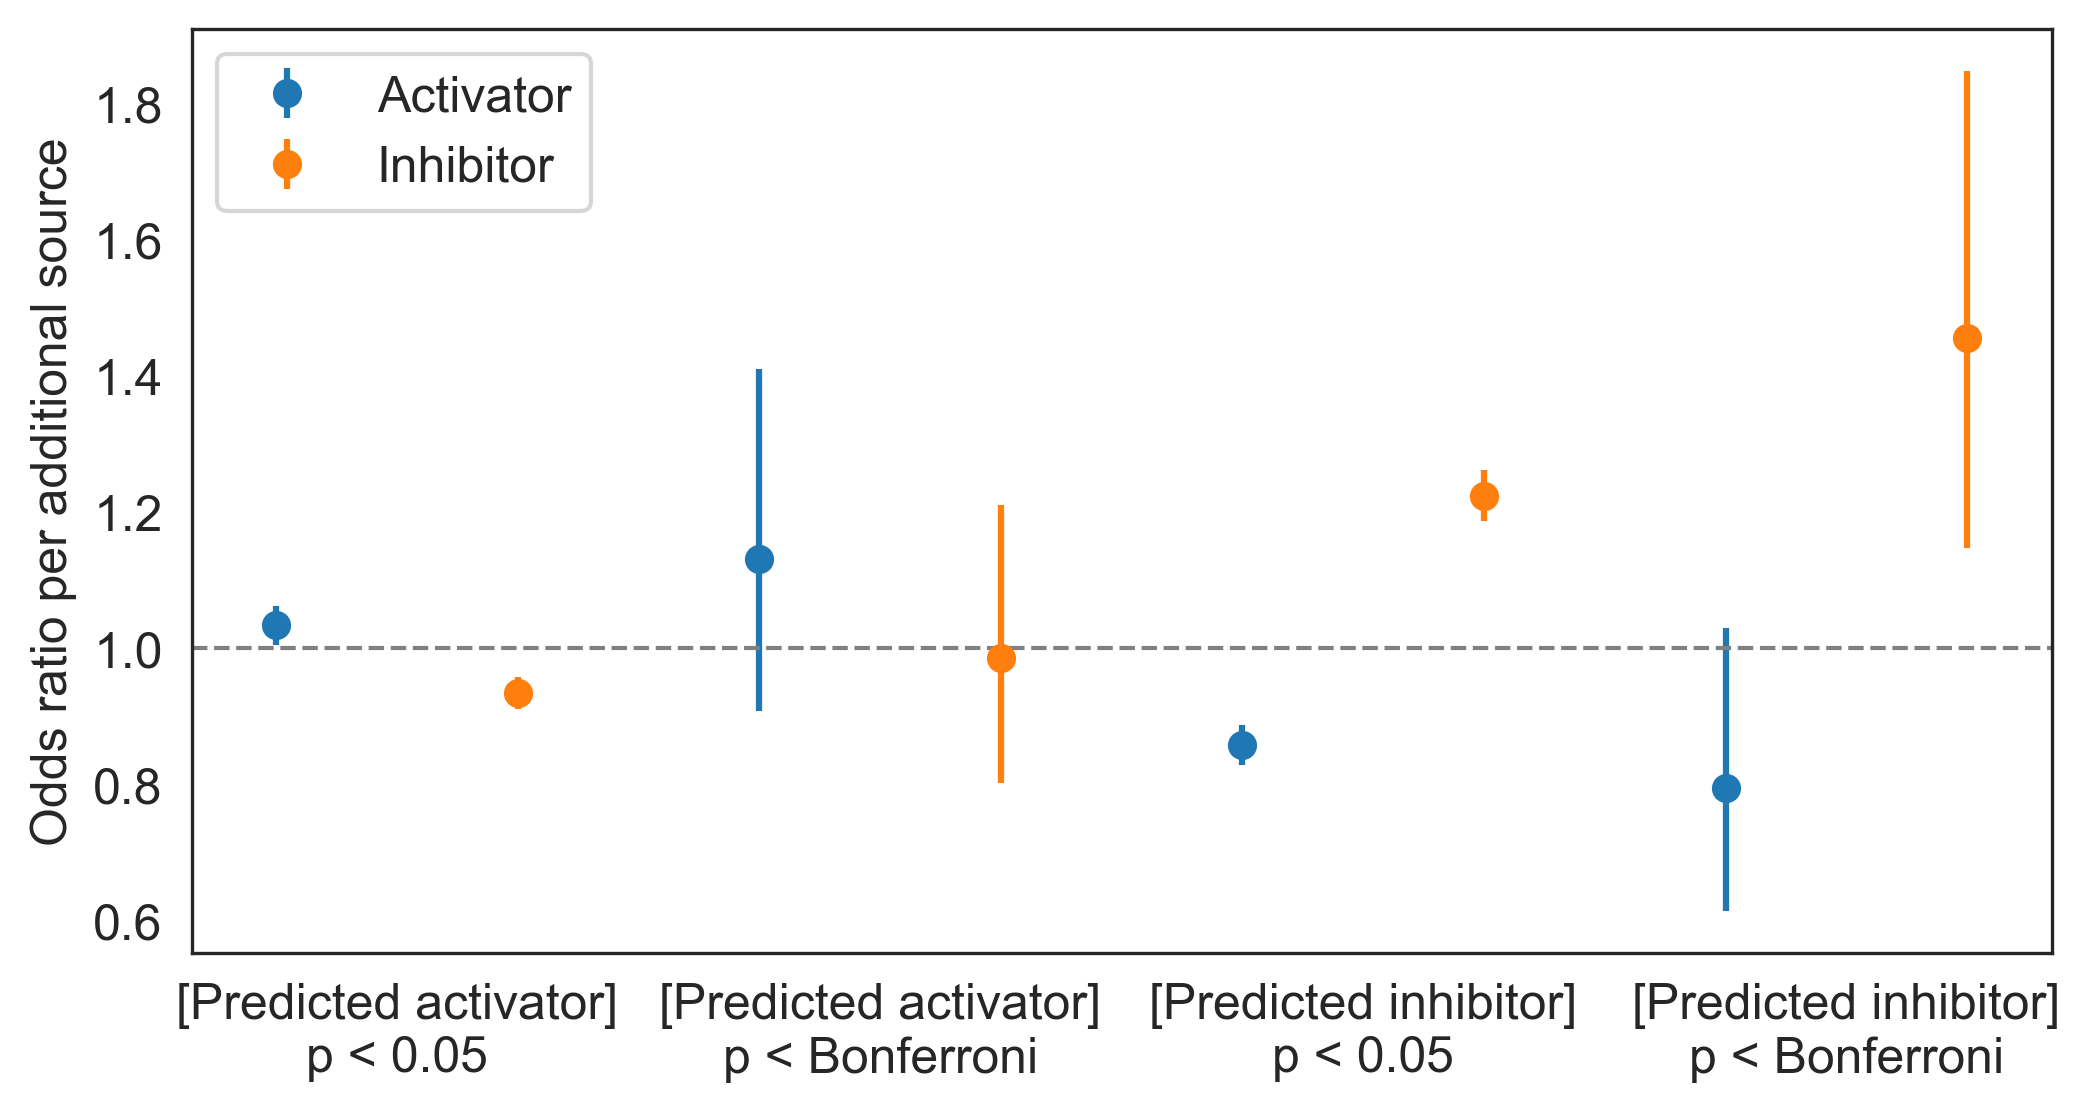

In [35]:
sns.set_style('white')

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
mechanisms = res['Mechanism'].unique()
offset = 0.5  # Offset for dodging
x_positions = range(len(res['Column'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['Mechanism'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['OR'], 
                yerr=[subset['OR'] - subset['CI_lower'], subset['CI_upper'] - subset['OR']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['Column'].unique())))
ax.set_xticklabels(res['Column'].unique())
ax.legend(title='', loc='upper left')

plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel('')
plt.ylabel('Odds ratio per additional source')


## Number of AF bins supporting mechanism

In [36]:
res = []
for col in ['activator_sources','inhibitor_sources']:
    for sc in [1,2,3]:
        temp2 = drugs[['neg','other','pos',col]]
        temp2['xvar'] = temp2[col].copy()
        temp2 = temp2.dropna(subset=['xvar'])
        temp2 = temp2.loc[temp2['xvar'].isin([0,sc])]
        temp2.loc[temp2['xvar'] == sc, 'xvar'] = 1
    
        if temp2['xvar'].abs().sum() >= 20:
            for mechanism in ['neg','pos','other']:
                X1 = sm.add_constant(temp2[['xvar']])
                y1 = temp2[mechanism]
                model1 = sm.Logit(y1, X1).fit(disp=0)
                or_1 = np.exp(model1.params['xvar'])
                ci_1 = np.exp(model1.conf_int().loc['xvar'])
                pval = model1.pvalues['xvar']
                res.append({'Column':col,'Mechanism':mechanism,'Sources':sc,
                            'OR':or_1,'CI_lower':ci_1[0],'CI_upper':ci_1[1],'p':pval})
                
res = pd.DataFrame(res)
res['Mechanism'] = res['Mechanism'].map({'neg':'Inhibitor','pos':'Activator','other':'Other'})
res = res.dropna().sort_values(['Column','Mechanism'])
res = res.loc[res['Mechanism'] != 'Other']
res['Label'] = res['Sources'].copy()


Text(0, 0.5, 'Odds ratio')

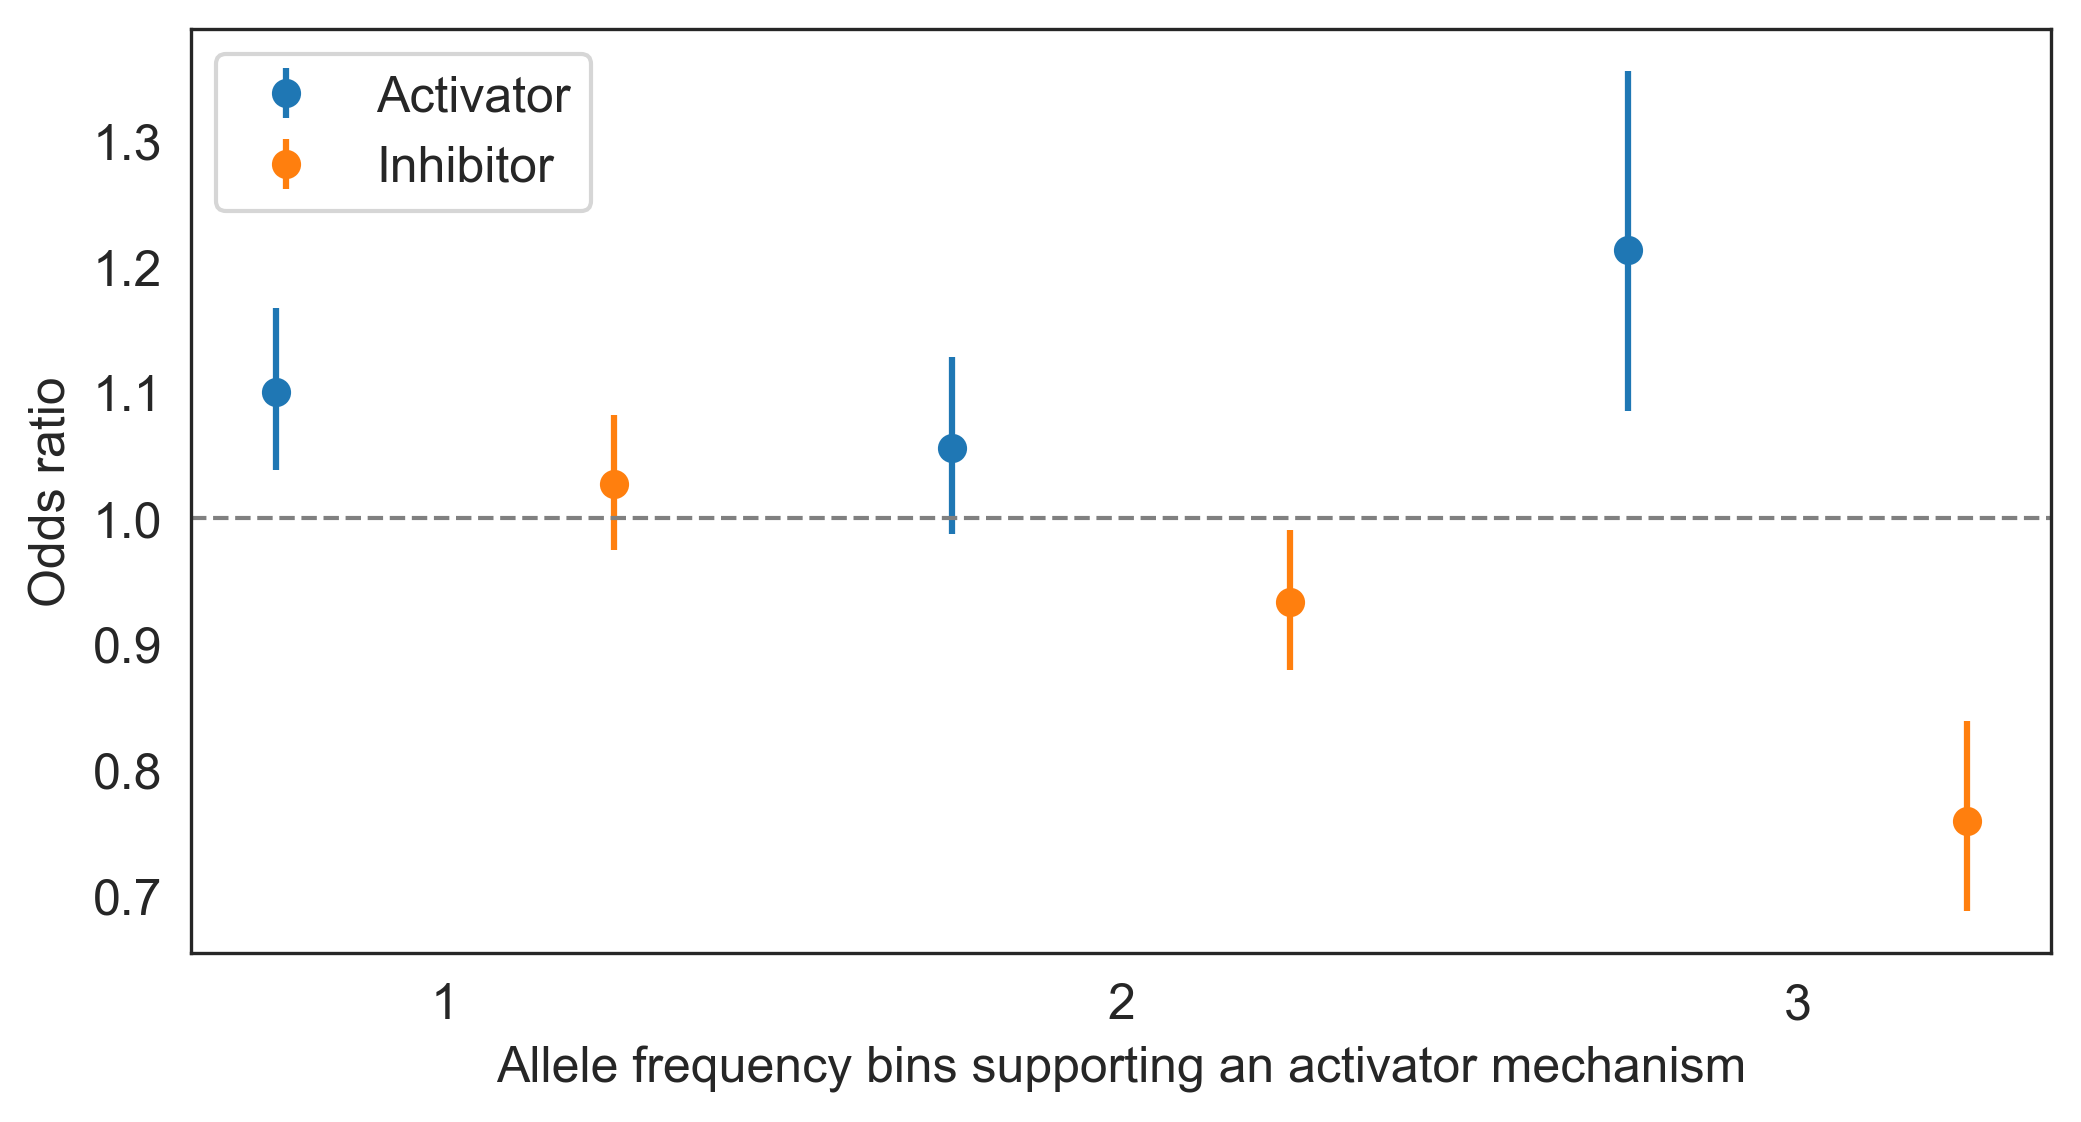

In [37]:
sns.set_style('white')

temp3 = res.loc[res['Column'].str.contains('activator')]

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
mechanisms = temp3['Mechanism'].unique()
offset = 0.5  # Offset for dodging
x_positions = range(len(temp3['Label'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = temp3[temp3['Mechanism'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['OR'], 
                yerr=[subset['OR'] - subset['CI_lower'], subset['CI_upper'] - subset['OR']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(temp3['Label'].unique())))
ax.set_xticklabels(temp3['Label'].unique())
ax.legend(title='', loc='upper left')

plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Allele frequency bins supporting an activator mechanism')
plt.ylabel('Odds ratio')


Text(0, 0.5, 'Odds ratio')

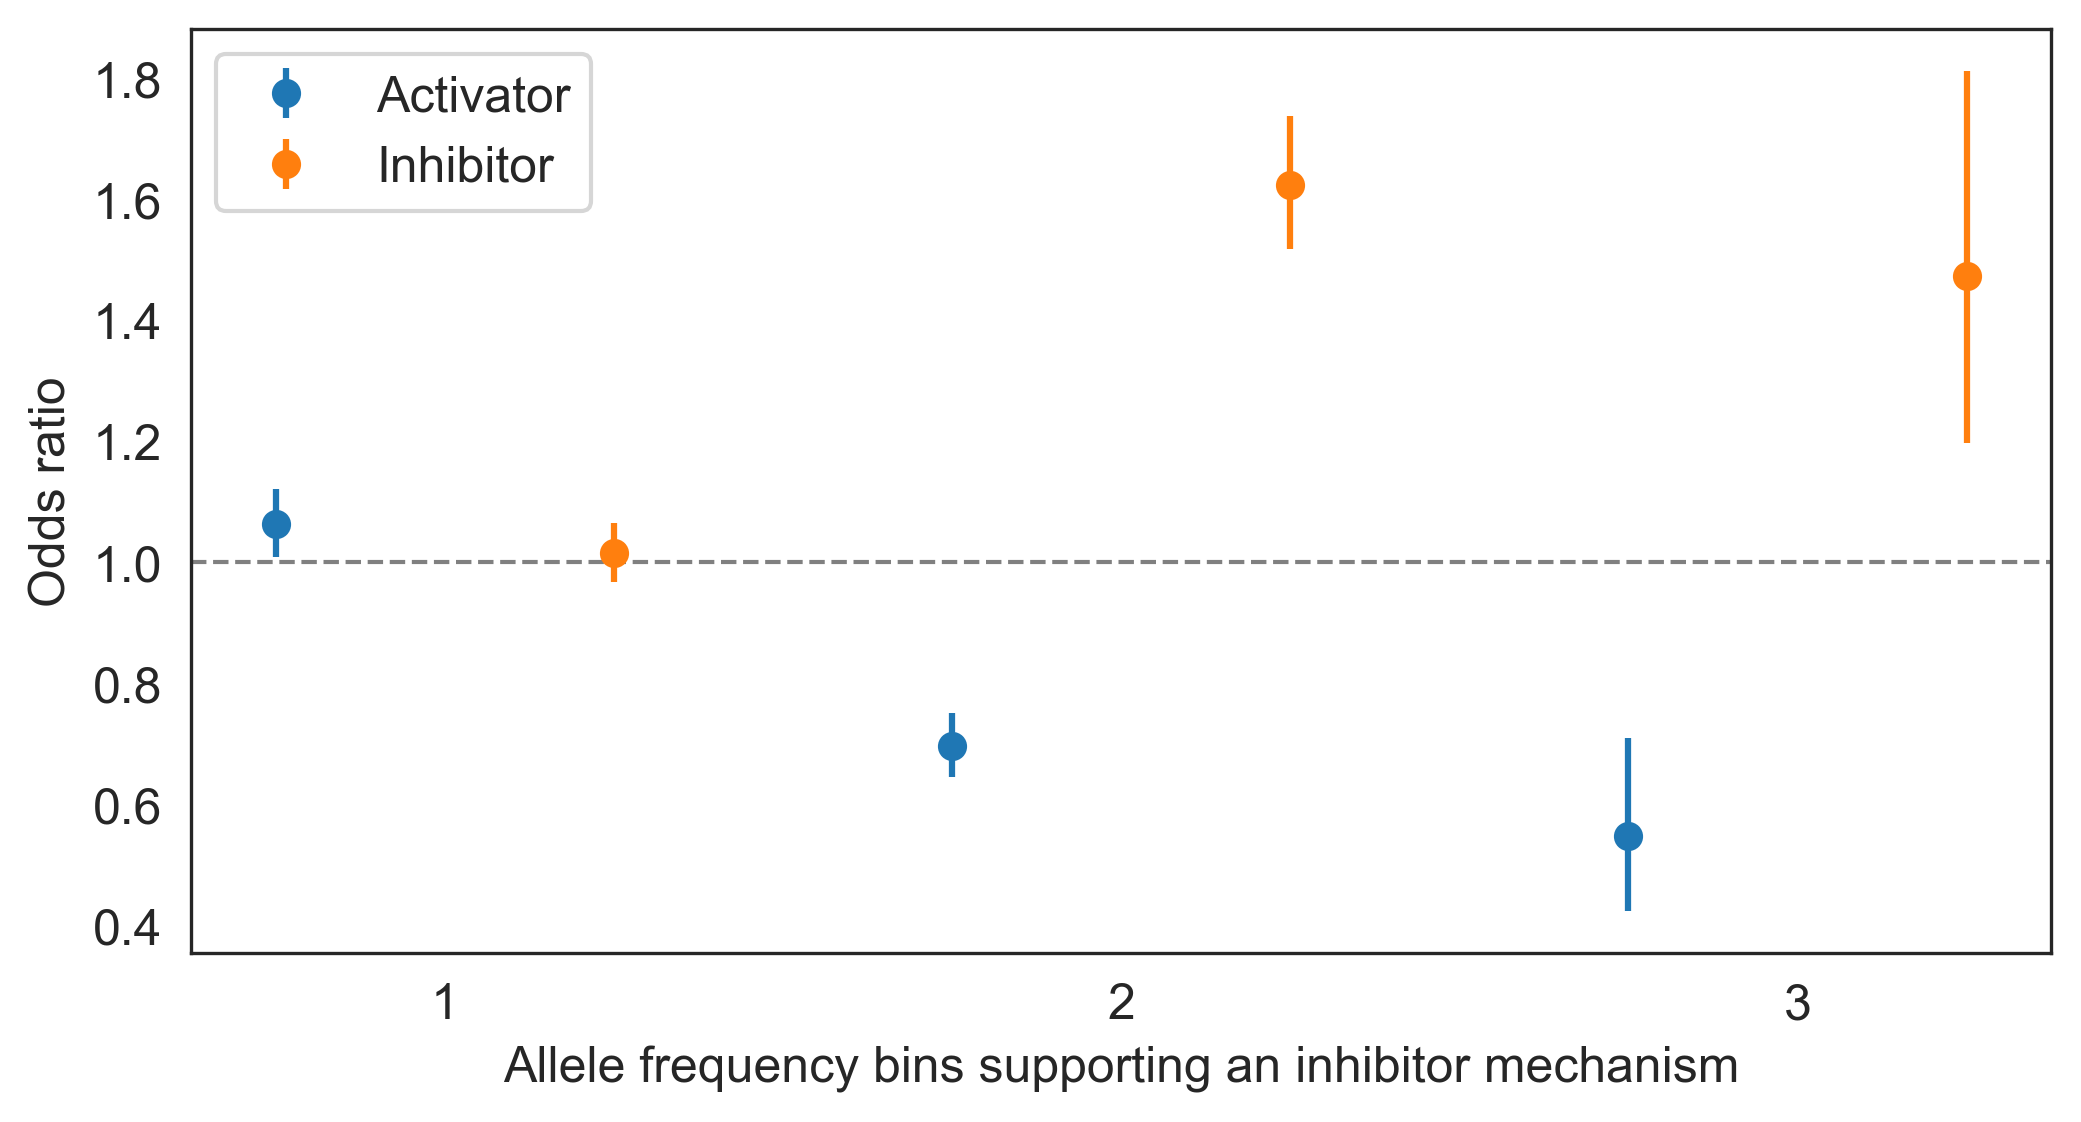

In [38]:
sns.set_style('white')

temp3 = res.loc[res['Column'].str.contains('inhibitor')]

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
mechanisms = temp3['Mechanism'].unique()
offset = 0.5  # Offset for dodging
x_positions = range(len(temp3['Label'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = temp3[temp3['Mechanism'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['OR'], 
                yerr=[subset['OR'] - subset['CI_lower'], subset['CI_upper'] - subset['OR']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(temp3['Label'].unique())))
ax.set_xticklabels(temp3['Label'].unique())
ax.legend(title='', loc='upper left')

plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Allele frequency bins supporting an inhibitor mechanism')
plt.ylabel('Odds ratio')


## Open Targets sources

In [53]:
res = []
for col in ['l2g_all','eva_hclof','eva_lclof','eva_gof','impc_lof']:
    temp2 = drugs[['neg','other','pos',col]]
    temp2['xvar'] = temp2[col].copy()
    temp2 = temp2.dropna(subset=['xvar'])
    temp2.loc[temp2['xvar'] > 0, 'xvar'] = 1
    temp2.loc[temp2['xvar'] < 0, 'xvar'] = -1
    
    if temp2['xvar'].abs().sum() >= 20:
        for mechanism in ['neg','pos','other']:
            X1 = sm.add_constant(temp2[['xvar']])
            y1 = temp2[mechanism]
            model1 = sm.Logit(y1, X1).fit(disp=0)
            or_1 = np.exp(model1.params['xvar'])
            ci_1 = np.exp(model1.conf_int().loc['xvar'])
            pval = model1.pvalues['xvar']
            res.append({'Column':col,'Mechanism':mechanism,'OR':or_1,'CI_lower':ci_1[0],'CI_upper':ci_1[1],'p':pval})
            
res = pd.DataFrame(res)
res['Mechanism'] = res['Mechanism'].map({'neg':'Inhibitor','pos':'Activator','other':'Other'})
res['Column'] = res['Column'].map({'l2g_all':'[Locus2gene]\nCis-eQTLs',
                                   'eva_gof':'[ClinVar]\nGOF variants',
                                   'eva_hclof':'[ClinVar]\nHC LOF variants',
                                   'eva_lclof':'[ClinVar]\nLC LOF variants',
                                   'impc_lof':'[IMPC]\nKnockout mice'})
res = res.dropna().sort_values(['Column','Mechanism'])
res = res.loc[res['Mechanism'] != 'Other']


Text(0, 0.5, 'Odds ratio')

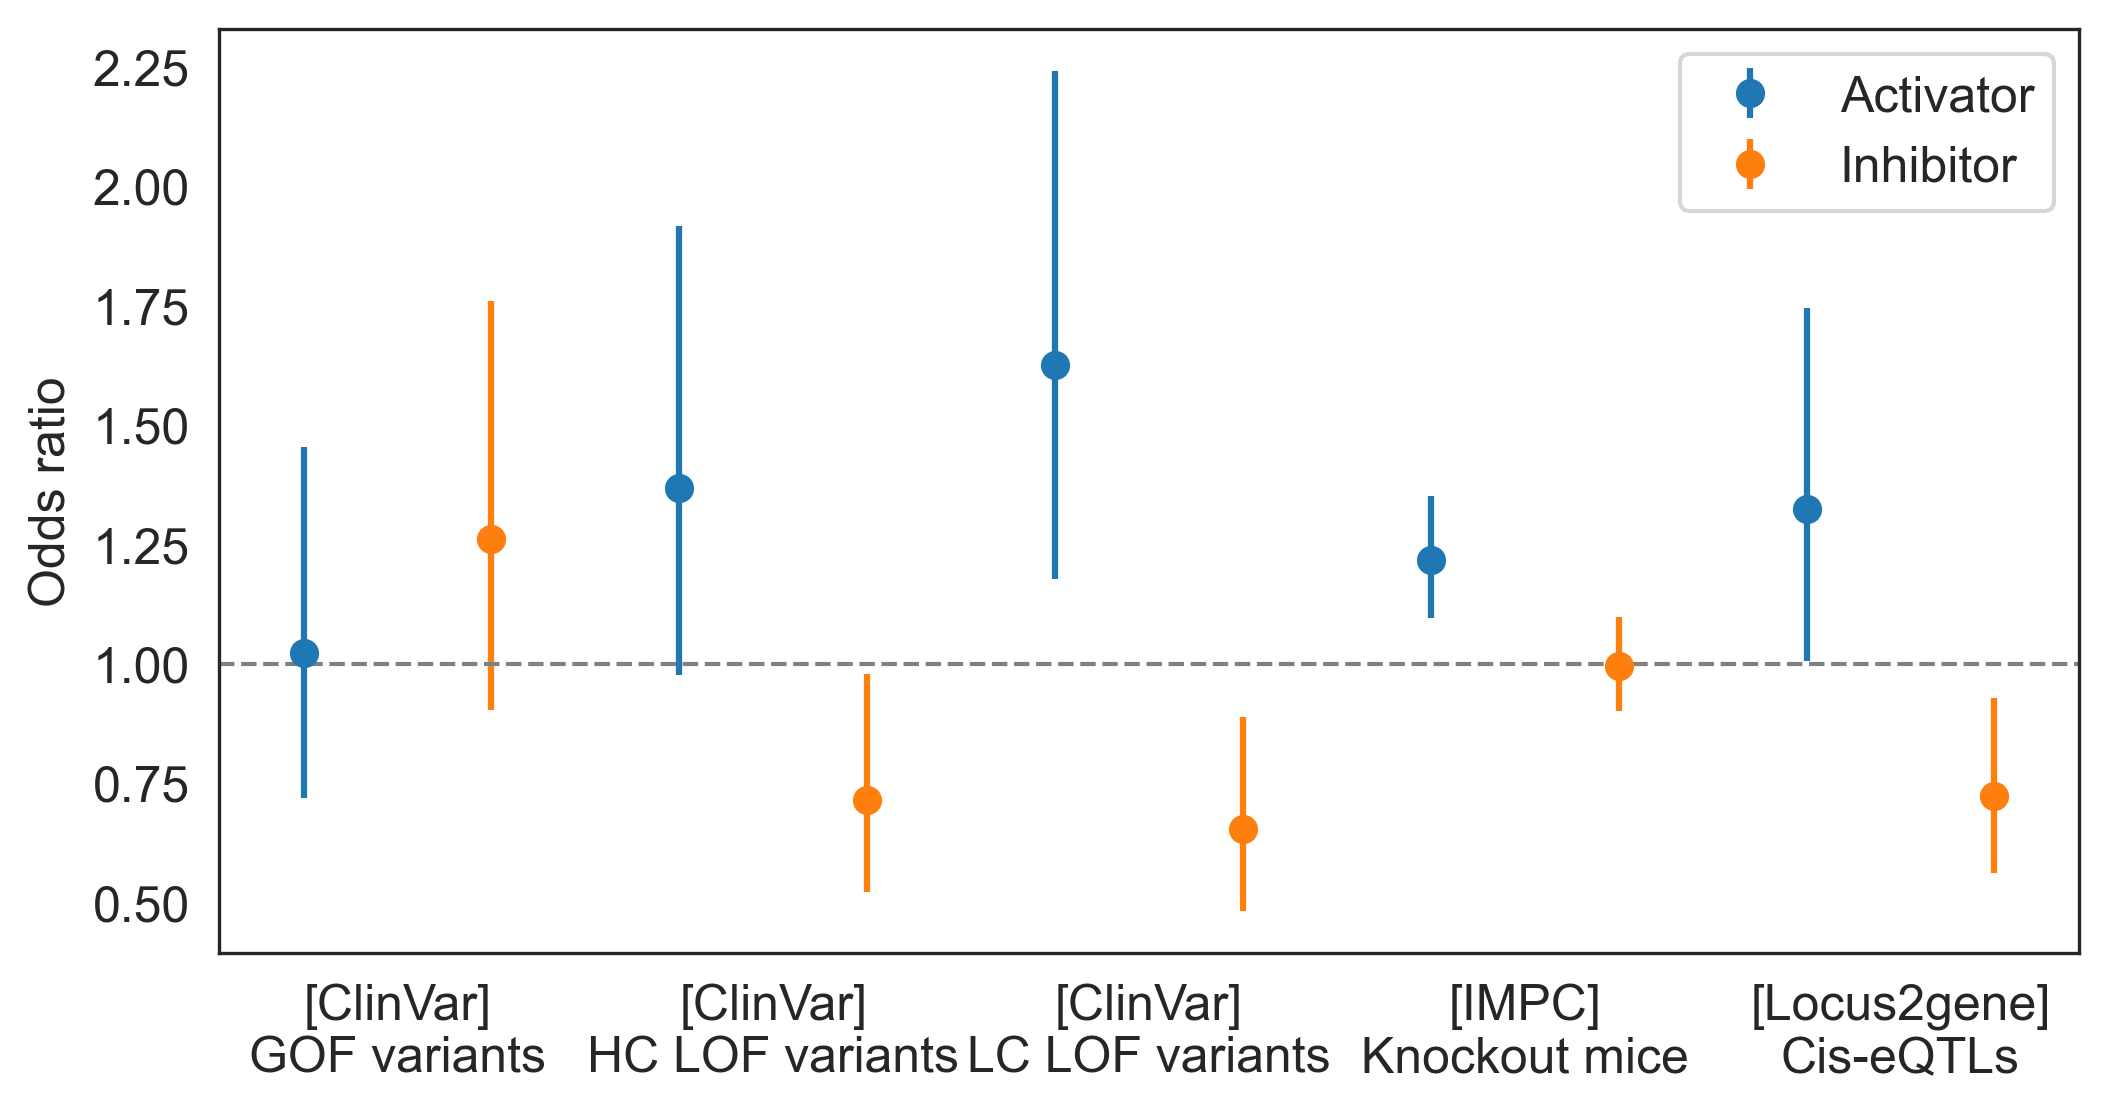

In [54]:
sns.set_style('white')

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
mechanisms = res['Mechanism'].unique()
offset = 0.5  # Offset for dodging
x_positions = range(len(res['Column'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['Mechanism'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['OR'], 
                yerr=[subset['OR'] - subset['CI_lower'], subset['CI_upper'] - subset['OR']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['Column'].unique())))
ax.set_xticklabels(res['Column'].unique())
ax.legend(title='')

plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel('')
plt.ylabel('Odds ratio')


## Rare variant LOF sources

In [71]:
res = []

for col in ['finngen_sv_hclof',
            'finngen_sv_lclof',
            'genebass_sv_hclof',
            'genebass_sv_lclof']:
    temp2 = drugs[['neg','pos','other',col]]
    temp2['xvar'] = temp2[col].copy()
    temp2 = temp2.dropna(subset=['xvar'])
    temp2.loc[temp2['xvar'] > 0, 'xvar'] = 1
    temp2.loc[temp2['xvar'] < 0, 'xvar'] = -1
    #temp2 = temp2.loc[temp2['xvar'] != 0]
    
    if temp2['xvar'].abs().sum() >= 20:
        for mechanism in ['neg','other','pos']:
            try:
                X1 = sm.add_constant(temp2[['xvar']])
                y1 = temp2[mechanism]
                model1 = sm.Logit(y1, X1).fit(disp=0)
                or_1 = np.exp(model1.params['xvar'])
                ci_1 = np.exp(model1.conf_int().loc['xvar'])
                pval = model1.pvalues['xvar']
                res.append({'Column':col,'Mechanism':mechanism,'OR':or_1,'CI_lower':ci_1[0],'CI_upper':ci_1[1],'p':pval})
            except:
                continue
                
res = pd.DataFrame(res)
res['Mechanism'] = res['Mechanism'].map({'neg':'Inhibitor','pos':'Activator','other':'Other'})
res['Column'] = res['Column'].map({'finngen_sv_hclof':'[FinnGen]\nHC LOF variants',
                                   'finngen_sv_lclof':'[FinnGen]\nLC LOF variants',
                                   'genebass_sv_hclof':'[Genebass]\nHC LOF variants',
                                   'genebass_sv_lclof':'[Genebass]\nLC LOF variants'})
res = res.dropna().sort_values(['Column','Mechanism'])
res = res.loc[res['Mechanism'] != 'Other']


Text(0, 0.5, 'Odds ratio')

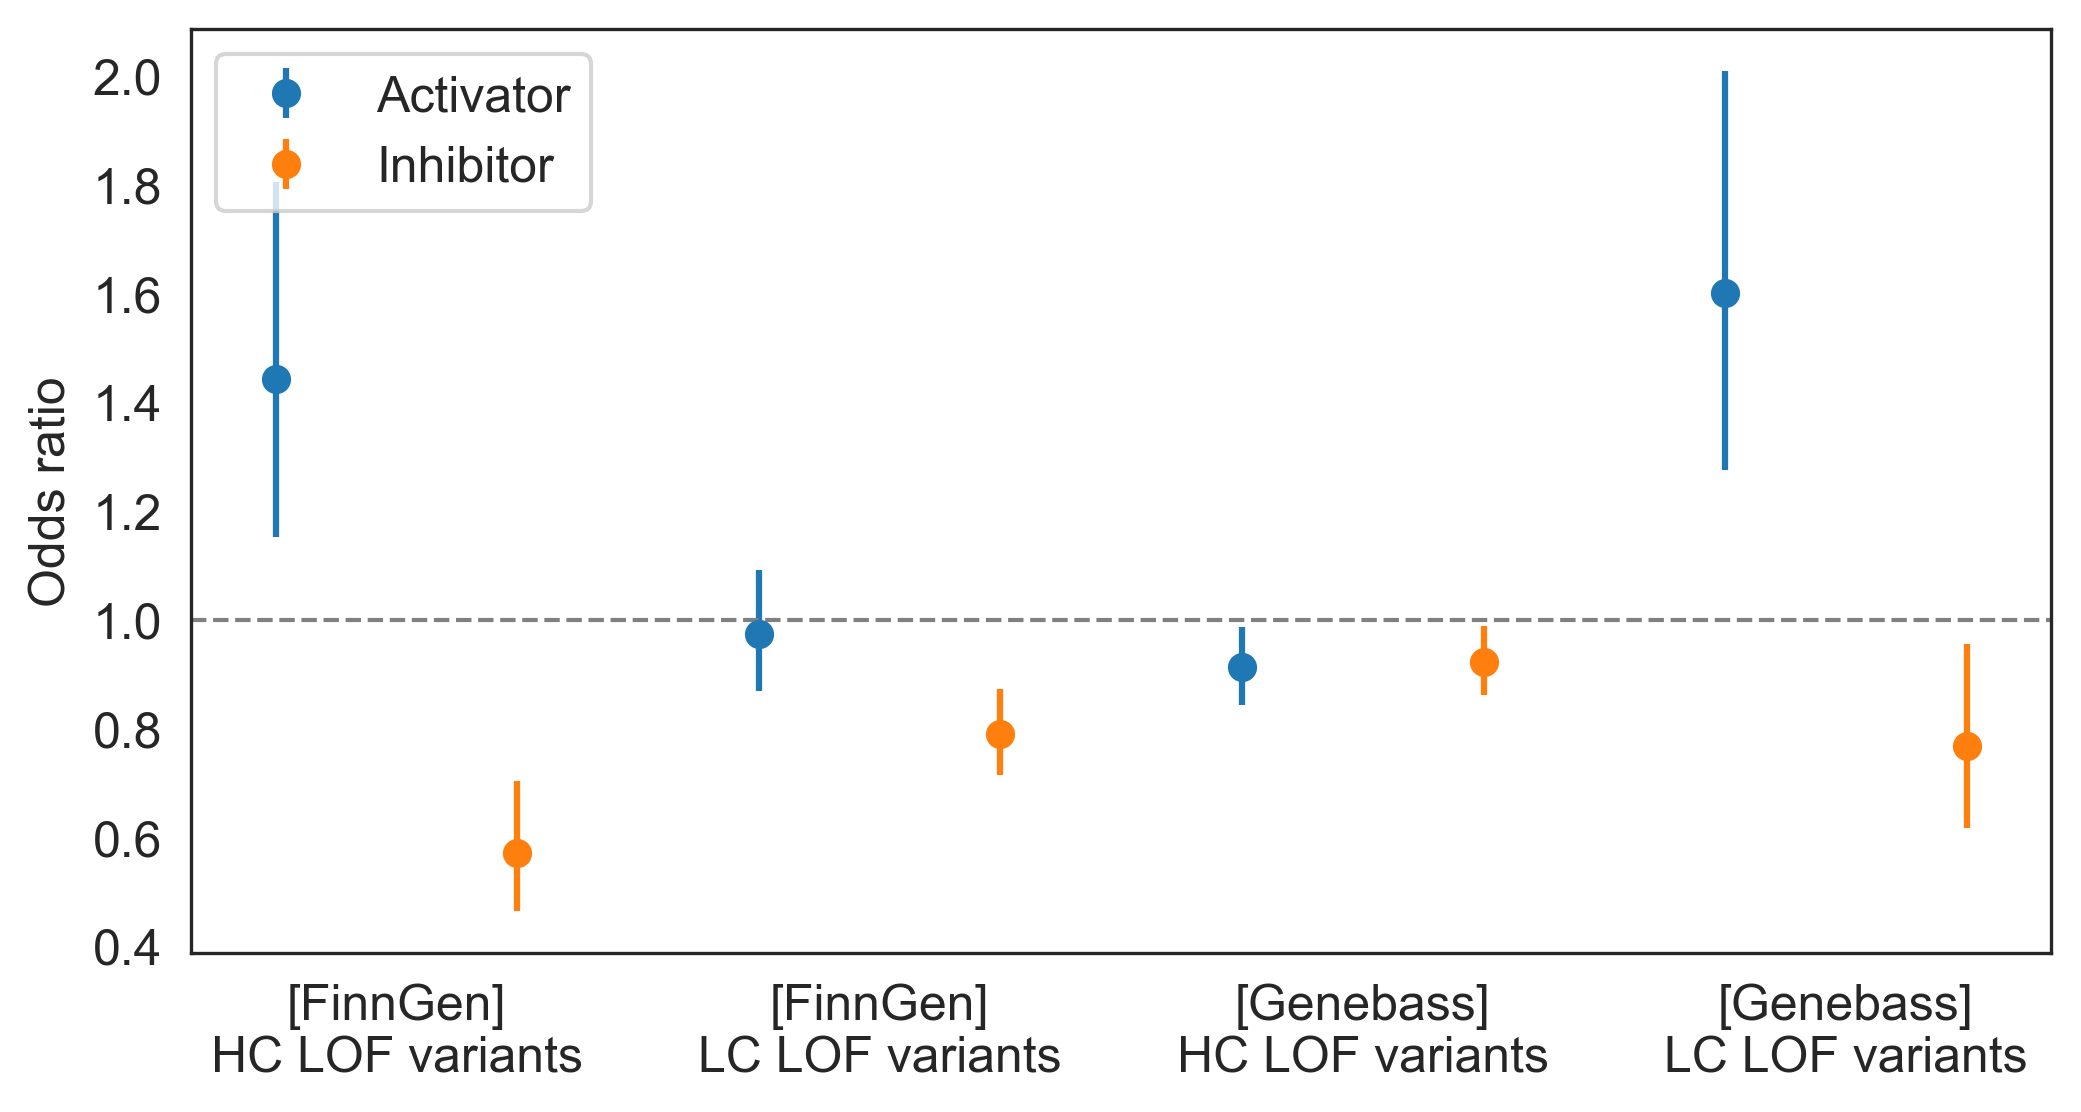

In [72]:
sns.set_style('white')

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
mechanisms = res['Mechanism'].unique()
offset = 0.5  # Offset for dodging
x_positions = range(len(res['Column'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['Mechanism'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['OR'], 
                yerr=[subset['OR'] - subset['CI_lower'], subset['CI_upper'] - subset['OR']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['Column'].unique())))
ax.set_xticklabels(res['Column'].unique())
ax.legend(title='', loc='upper left')

plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel('')
plt.ylabel('Odds ratio')


## Rare variant GOF sources

In [12]:
res = []

for col in ['genebass_sv_gof_0.5missense',
            'genebass_sv_gof_missense',
            'genebass_sv_hcgof',
            'finngen_sv_gof']:
    temp2 = drugs[['neg','pos','other',col]]
    temp2['xvar'] = temp2[col].copy()
    temp2 = temp2.dropna(subset=['xvar'])
    temp2.loc[temp2['xvar'] > 0, 'xvar'] = 1
    temp2.loc[temp2['xvar'] < 0, 'xvar'] = -1
    #temp2 = temp2.loc[temp2['xvar'] != 0]

    if temp2['xvar'].abs().sum() >= 10:
        for mechanism in ['neg','other','pos']:
            try:
                X1 = sm.add_constant(temp2[['xvar']])
                y1 = temp2[mechanism]
                model1 = sm.Logit(y1, X1).fit(disp=0)
                or_1 = np.exp(model1.params['xvar'])
                ci_1 = np.exp(model1.conf_int().loc['xvar'])
                pval = model1.pvalues['xvar']
                res.append({'Column':col,'Mechanism':mechanism,'OR':or_1,'CI_lower':ci_1[0],'CI_upper':ci_1[1],'p':pval})
            except:
                continue
                
res = pd.DataFrame(res)
res['Mechanism'] = res['Mechanism'].map({'neg':'Inhibitor','pos':'Activator','other':'Other'})
res['Column'] = res['Column'].map({'finngen_sv_gof':'[FinnGen]\nAll GOF variants',
                                   'genebass_sv_hcgof':'[Genebass]\nHC GOF variants',
                                   'genebass_sv_gof_missense':'[Genebass]\nAll GOF variants'})
res = res.dropna().sort_values(['Column','Mechanism'])
res = res.loc[res['Mechanism'] != 'Other']


Text(0, 0.5, 'Odds ratio')

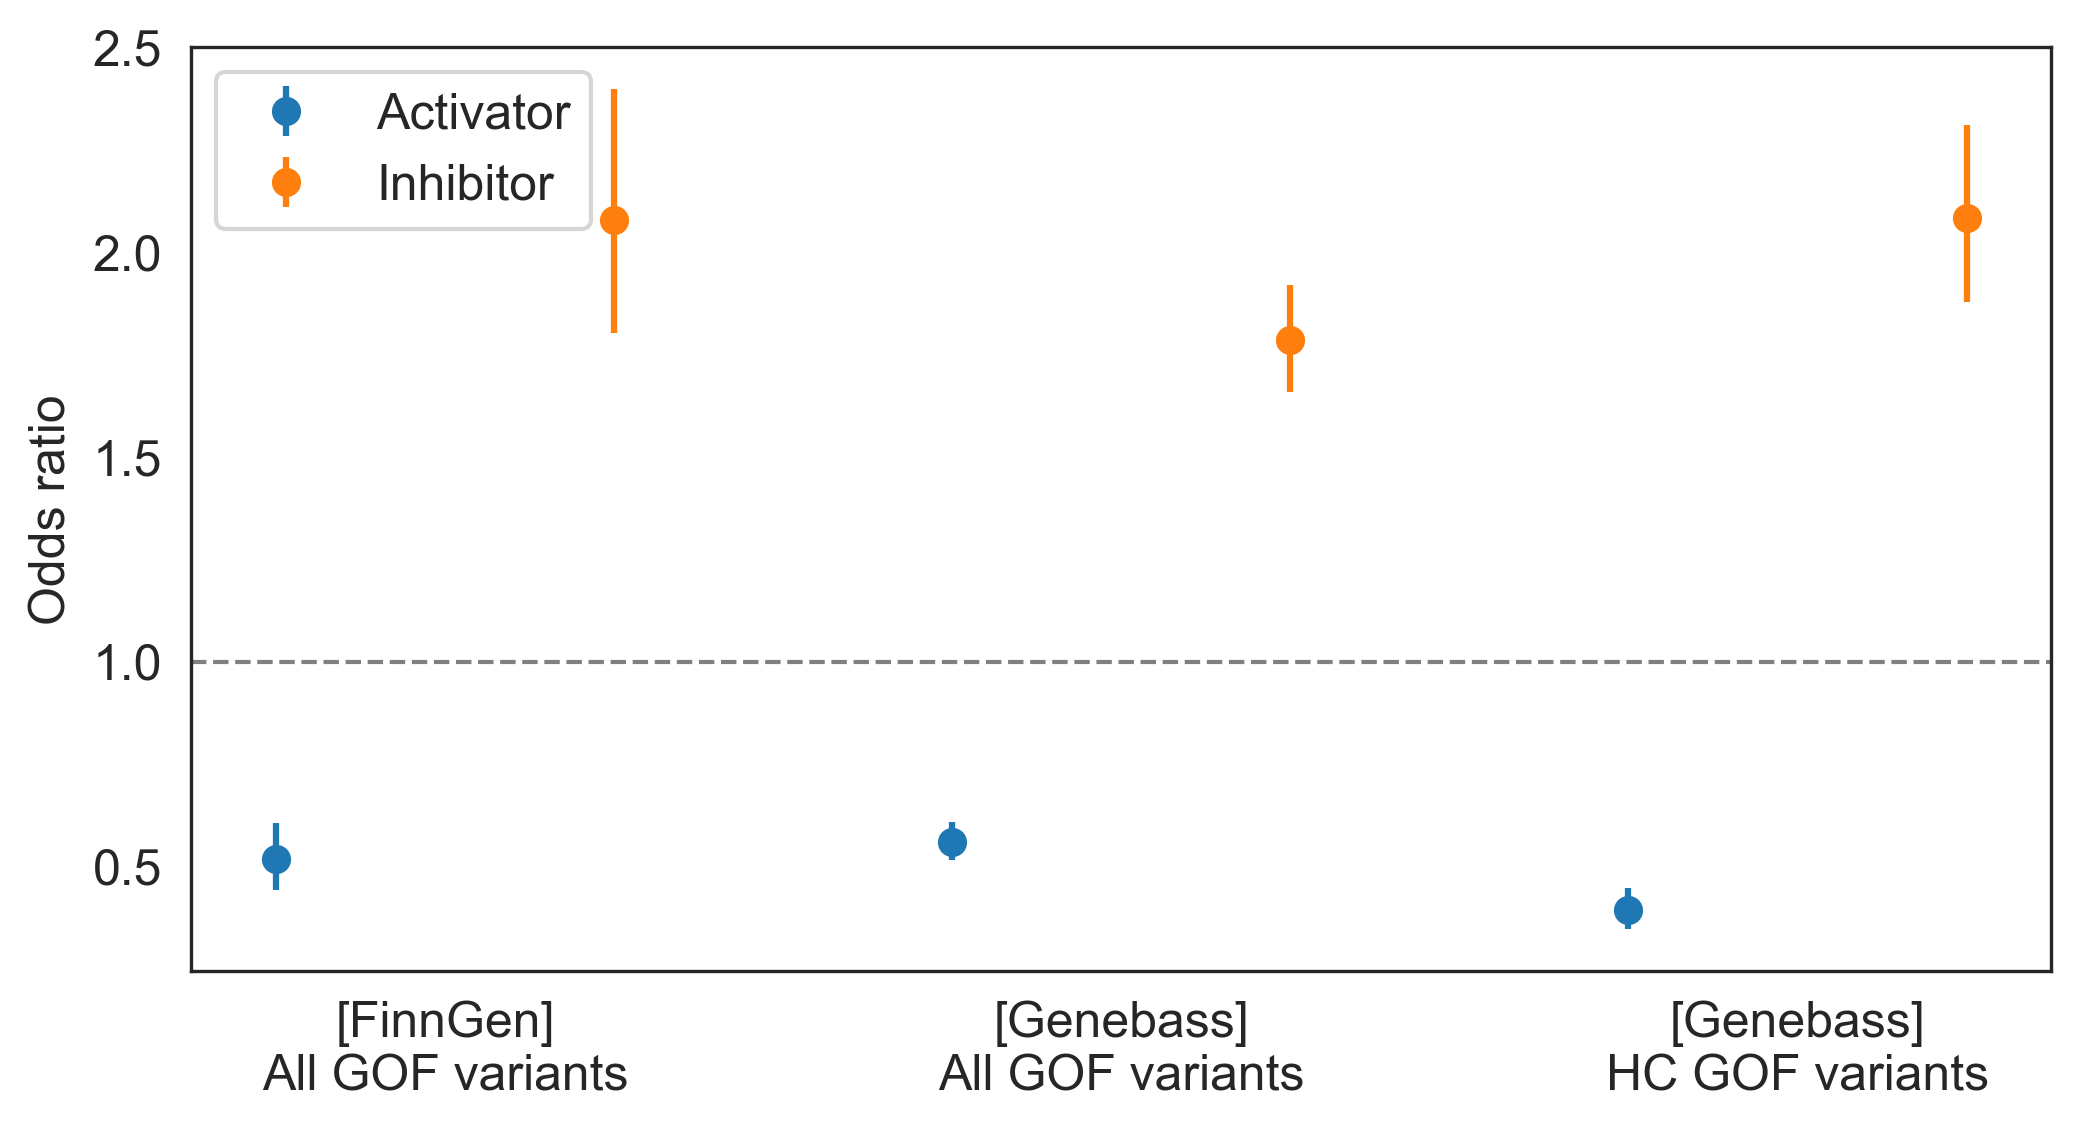

In [13]:
sns.set_style('white')

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
mechanisms = res['Mechanism'].unique()
offset = 0.5  # Offset for dodging
x_positions = range(len(res['Column'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['Mechanism'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['OR'], 
                yerr=[subset['OR'] - subset['CI_lower'], subset['CI_upper'] - subset['OR']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['Column'].unique())))
ax.set_xticklabels(res['Column'].unique())
ax.legend(title='')

plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel('')
plt.ylabel('Odds ratio')


## Gene burden sources

In [14]:
res = []
for col in ['finngen_gb_lof',
            'genebass_gb_hclof_missense',
            'genebass_gb_hclof',
            'genebass_gb_hclof_lclof_missense',
            'jurgens_lof',
            'jurgens_lof_0.5missense',
            'jurgens_lof_0.8missense']:
    temp2 = drugs[['neg','other','pos',col]]
    temp2['xvar'] = temp2[col].copy()
    temp2 = temp2.dropna(subset=['xvar'])
    temp2.loc[temp2['xvar'] > 0, 'xvar'] = 1
    temp2.loc[temp2['xvar'] < 0, 'xvar'] = -1
    #temp2 = temp2.loc[temp2['xvar'] != 0]

    if temp2['xvar'].abs().sum() >= 10:
        for mechanism in ['neg','pos','other']:
            try:
                X1 = sm.add_constant(temp2[['xvar']])
                y1 = temp2[mechanism]
                model1 = sm.Logit(y1, X1).fit(disp=0)
                or_1 = np.exp(model1.params['xvar'])
                ci_1 = np.exp(model1.conf_int().loc['xvar'])
                pval = model1.pvalues['xvar']
                res.append({'Column':col,'Mechanism':mechanism,'OR':or_1,'CI_lower':ci_1[0],'CI_upper':ci_1[1],'p':pval})
            except:
                continue
                
res = pd.DataFrame(res)
res['Mechanism'] = res['Mechanism'].map({'neg':'Inhibitor','pos':'Activator','other':'Other'})
res['Column'] = res['Column'].map({'finngen_gb_lof':'[FinnGen]\nAll LOF burden',
                                    'genebass_gb_hclof':'[Genebass]\nHC LOF burden',
                                    'genebass_gb_hclof_lclof_missense':'[Genebass]\nAll LOF burden',
                                    'jurgens_lof':'[Jurgens]\nHC LOF burden'})
res = res.dropna().sort_values(['Column','Mechanism'])
res = res.loc[res['Mechanism'] != 'Other']


Text(0, 0.5, 'Odds ratio')

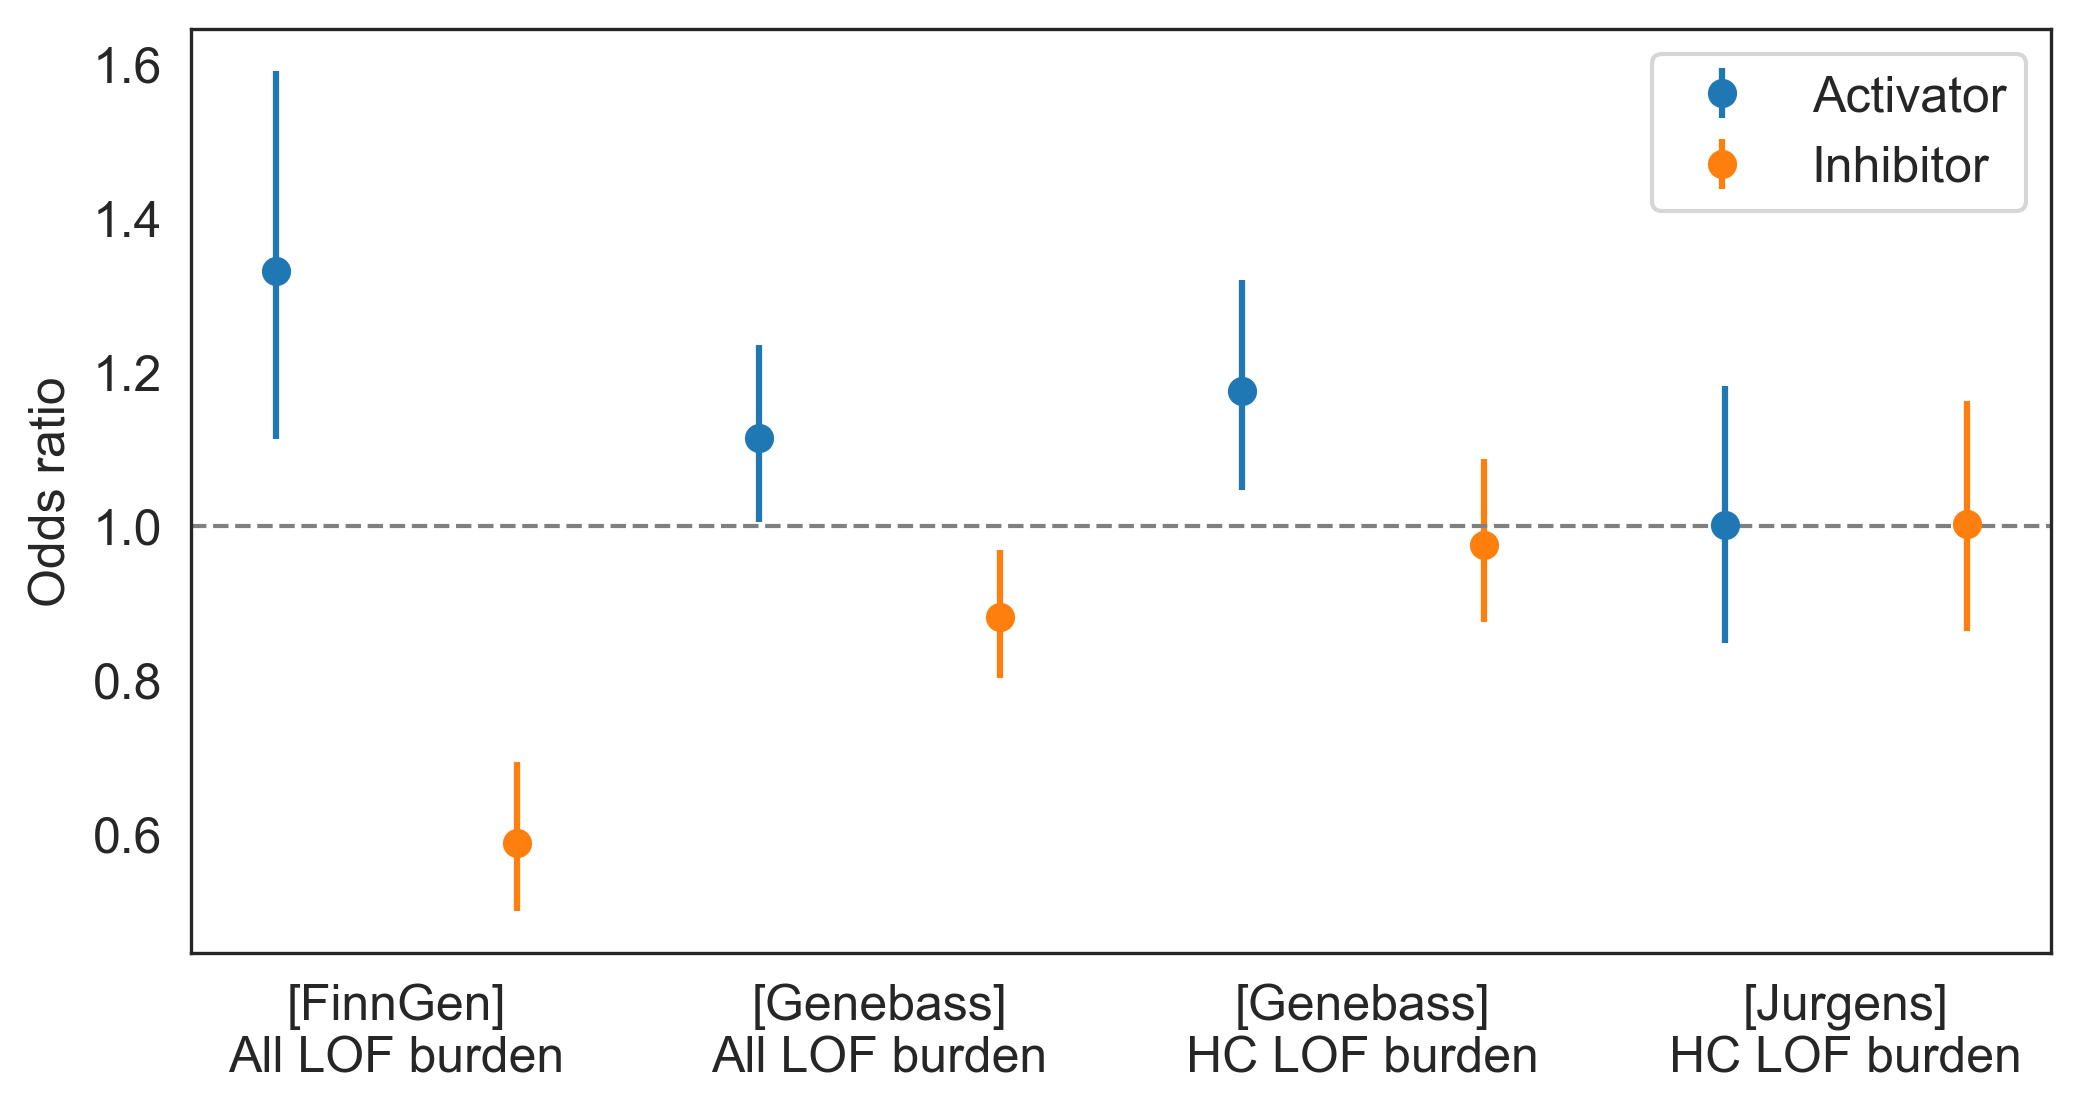

In [15]:
sns.set_style('white')

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
mechanisms = res['Mechanism'].unique()
offset = 0.5  # Offset for dodging
x_positions = range(len(res['Column'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['Mechanism'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['OR'], 
                yerr=[subset['OR'] - subset['CI_lower'], subset['CI_upper'] - subset['OR']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['Column'].unique())))
ax.set_xticklabels(res['Column'].unique())
ax.legend(title='')

plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel('')
plt.ylabel('Odds ratio')


## eQTL sources

In [80]:
res = []
for col in ['panukbb_eqtl','finngen_eqtl','mvp_eqtl']:
    temp2 = drugs[['neg','other','pos',col]]
    temp2['xvar'] = temp2[col].copy()
    temp2 = temp2.dropna(subset=['xvar'])
    temp2.loc[temp2['xvar'] > 0, 'xvar'] = 1
    temp2.loc[temp2['xvar'] < 0, 'xvar'] = -1
    #temp2 = temp2.loc[temp2['xvar'] != 0]

    if temp2['xvar'].abs().sum() >= 10:
        for mechanism in ['neg','pos','other']:
            X1 = sm.add_constant(temp2[['xvar']])
            y1 = temp2[mechanism]
            model1 = sm.Logit(y1, X1).fit(disp=0)
            or_1 = np.exp(model1.params['xvar'])
            ci_1 = np.exp(model1.conf_int().loc['xvar'])
            pval = model1.pvalues['xvar']
            res.append({'Column':col,'Mechanism':mechanism,'OR':or_1,'CI_lower':ci_1[0],'CI_upper':ci_1[1],'p':pval})
            
res = pd.DataFrame(res)
res['Mechanism'] = res['Mechanism'].map({'neg':'Inhibitor','pos':'Activator','other':'Other'})
res['Column'] = res['Column'].map({'finngen_eqtl':'[FinnGen] Cis-eQTLs',
                                   'mvp_eqtl':'[MVP] Cis-eQTLs',
                                   'panukbb_eqtl':'[Pan UKBB] Cis-eQTLs'})
res = res.dropna().sort_values(['Column','Mechanism'])
res = res.loc[res['Mechanism'] != 'Other']


Text(0, 0.5, 'Odds ratio')

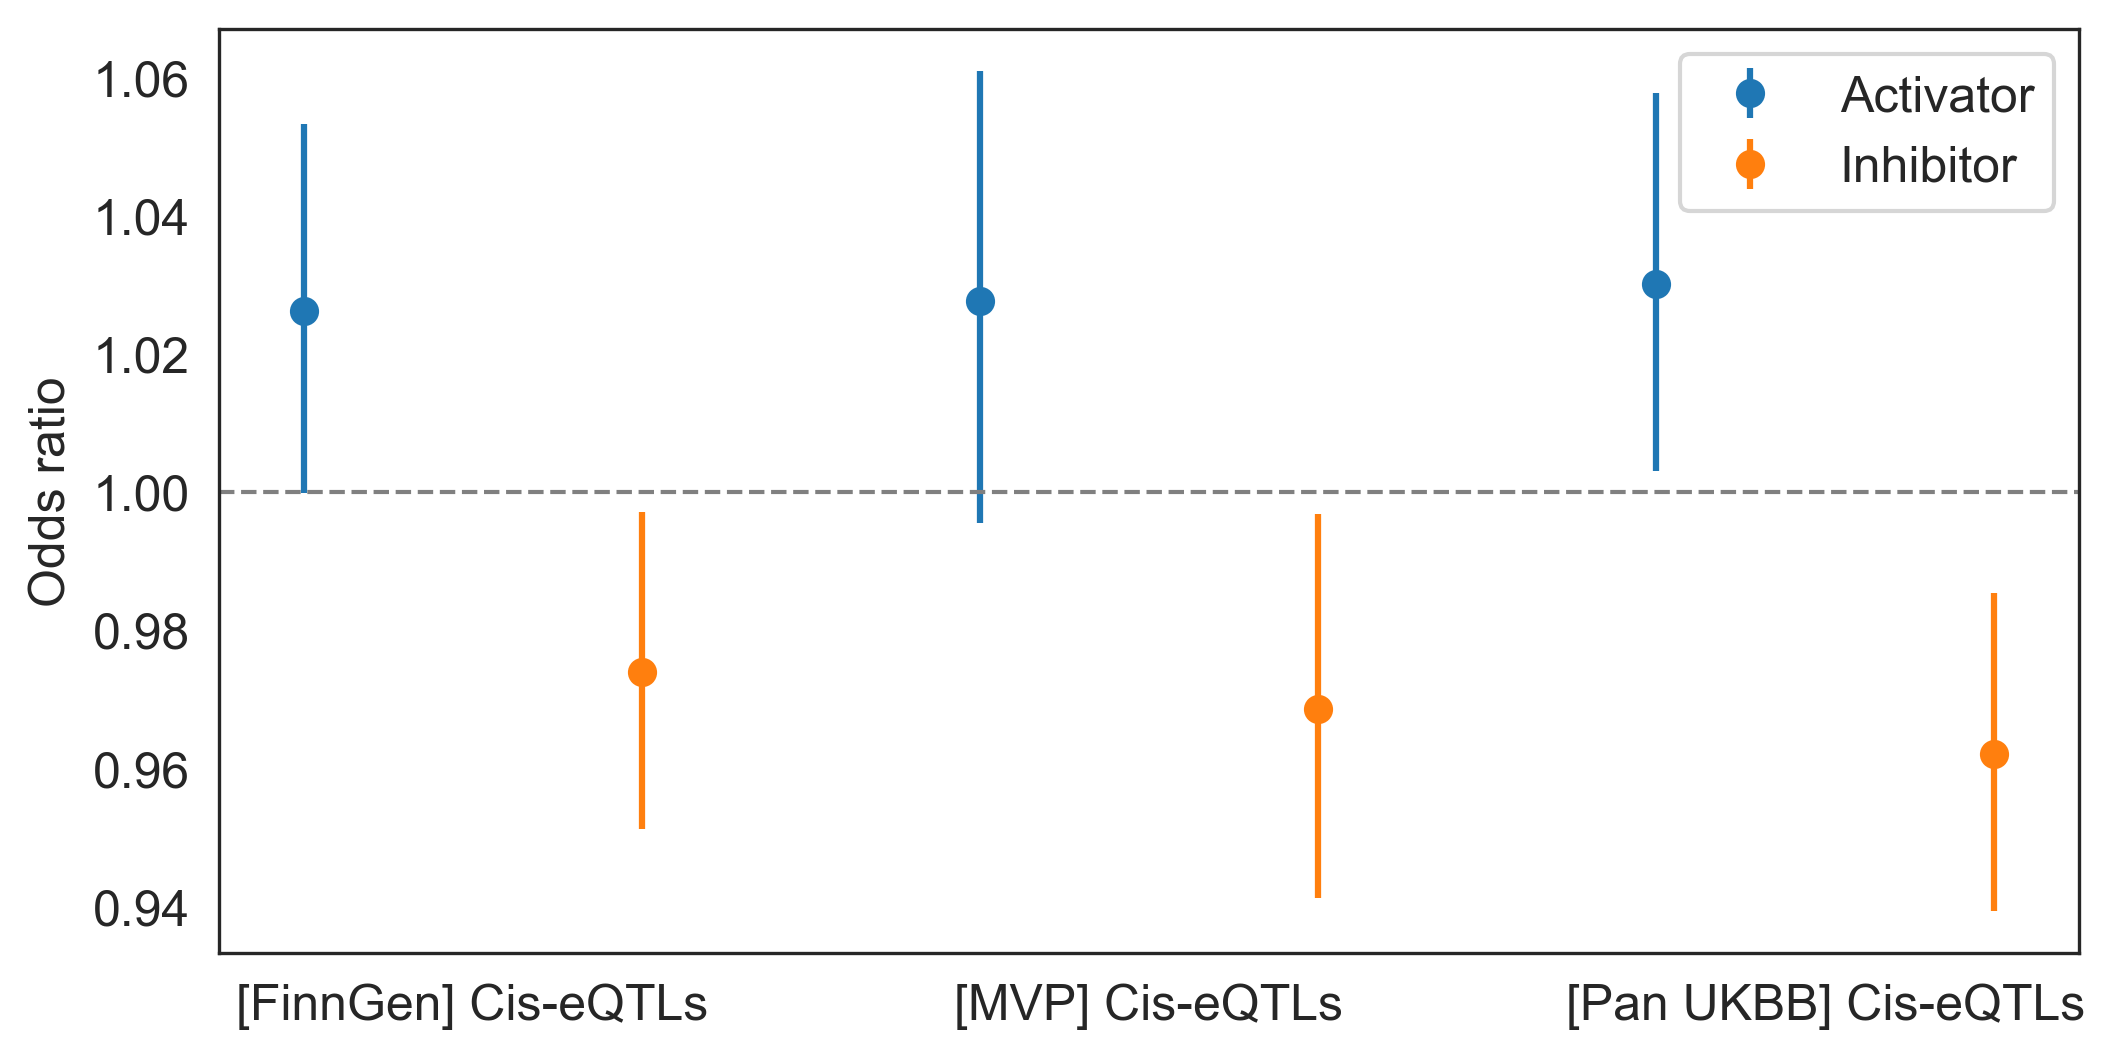

In [81]:
sns.set_style('white')

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
mechanisms = res['Mechanism'].unique()
offset = 0.5  # Offset for dodging
x_positions = range(len(res['Column'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['Mechanism'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['OR'], 
                yerr=[subset['OR'] - subset['CI_lower'], subset['CI_upper'] - subset['OR']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['Column'].unique())))
ax.set_xticklabels(res['Column'].unique())
ax.legend(title='')

plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel('')
plt.ylabel('Odds ratio')


# Phenotype-agnostic

In [2]:
genes = pd.read_pickle('./OT/Final/protein_coding_genes.pkl')
genes['label'] = 'All protein coding'
genes = genes.loc[~genes['gene'].str.contains('ENSG')]

tg = pd.read_pickle('./Drugs/targets.pkl')[['gene','moa']]
tg = tg.loc[tg['gene'].isin(genes['gene'])]
tg['value'] = 1
tg = pd.pivot_table(tg, index='gene', columns='moa', values='value').fillna(0).reset_index()
tg = tg.set_axis(['gene','neg','other','pos'],axis=1)

cs = pd.read_pickle('./Features/constraint.pkl')
tg.loc[tg['gene'].isin(cs.dropna(subset='lof.oe_ci.upper')['gene']), 'constrained'] = 0
tg.loc[tg['gene'].isin(cs.loc[cs['lof.oe_ci.upper'] < 0.6]['gene']), 'constrained'] = 1
tg.loc[tg['gene'].isin(cs.dropna(subset='lof.pLI')['gene']), 'pLI'] = 0
tg.loc[tg['gene'].isin(cs.loc[cs['lof.pLI'] < 0.04575749056]['gene']), 'pLI'] = 1

tp = pd.read_pickle('./Features/tp.pkl').fillna(0)
tg = tg.merge(tp[['gene','loc_intracellular','loc_membrane','loc_secreted','loc_plasma','class_enzyme',
                  'class_transporter','class_tf','class_gpcr','class_vgic']], how='left')

ess = pd.read_pickle('./Features/ess_haplo.pkl')
tg = tg.merge(ess[['gene','omim_ad','omim_ar']].fillna(0), how='left')
tg.loc[tg['gene'].isin(ess.dropna(subset='impc_ko')['gene']), 'impc'] = 0
tg.loc[tg['gene'].isin(ess.loc[ess['impc_ko'] == 2]['gene']), 'impc'] = 1
tg.loc[tg['gene'].isin(ess.dropna(subset='collins_phaplo')['gene']), 'phaplo'] = 0
tg.loc[tg['gene'].isin(ess.loc[ess['collins_phaplo'] >= 0.86]['gene']), 'phaplo'] = 1
tg.loc[tg['gene'].isin(ess.dropna(subset='collins_ptriplo')['gene']), 'ptriplo'] = 0
tg.loc[tg['gene'].isin(ess.loc[ess['collins_ptriplo'] >= 0.94]['gene']), 'ptriplo'] = 1
tg.loc[tg['gene'].isin(ess.dropna(subset=['collins_phaplo','collins_ptriplo'])['gene']), 'bds'] = 0
tg.loc[(tg['gene'].isin(ess.loc[ess['collins_ptriplo'] >= 0.94]['gene'])) & (tg['gene'].isin(ess.loc[ess['collins_phaplo'] >= 0.86]['gene'])), 'bds'] = 1
tg = tg.drop_duplicates('gene')


## Statistics for paper

In [111]:
cn = tg.loc[tg['neg'] == 1]
cn = cn.dropna(subset=['constrained','bds'])
X1 = sm.add_constant(cn['constrained'])
y1 = cn['bds']
model1 = sm.Logit(y1, X1).fit(disp=0)
or_1 = np.exp(model1.params['constrained'])
ci_1 = np.exp(model1.conf_int().loc['constrained'])
pval = model1.pvalues['constrained']
print(or_1,ci_1[0],ci_1[1],pval)

cn = tg.loc[tg['neg'] == 1]
cn = cn.dropna(subset=['constrained','ptriplo'])
X1 = sm.add_constant(cn['constrained'])
y1 = cn['ptriplo']
model1 = sm.Logit(y1, X1).fit(disp=0)
or_1 = np.exp(model1.params['constrained'])
ci_1 = np.exp(model1.conf_int().loc['constrained'])
pval = model1.pvalues['constrained']
print(or_1,ci_1[0],ci_1[1],pval)


19.58423326133906 12.143259757496088 31.584780371495967 3.1600373870943473e-34
10.784835384103747 7.963591036577589 14.605555926714494 2.6083958133638965e-53


In [136]:
data = pd.read_pickle('./OT/Final/gene_direction_all.pkl')
data = data.loc[data['neg'] == 1]
data.loc[data['lof.oe_ci.upper'] >= 0.6, 'constrained'] = 0
data.loc[data['lof.oe_ci.upper'] < 0.6, 'constrained'] = 1
data['oncokb_oncogene'] = data['oncokb_oncogene'].fillna(0)
data['gofcards'] = data['gofcards'].fillna(0)

cn = data.copy()
cn = cn.dropna(subset=['constrained','oncokb_oncogene'])
X1 = sm.add_constant(cn['constrained'])
y1 = cn['oncokb_oncogene']
model1 = sm.Logit(y1, X1).fit(disp=0)
or_1 = np.exp(model1.params['constrained'])
ci_1 = np.exp(model1.conf_int().loc['constrained'])
pval = model1.pvalues['constrained']
print(or_1,ci_1[0],ci_1[1],pval)

cn = data.copy()
cn = cn.dropna(subset=['constrained','gofcards'])
X1 = sm.add_constant(cn['constrained'])
y1 = cn['gofcards']
model1 = sm.Logit(y1, X1).fit(disp=0)
or_1 = np.exp(model1.params['constrained'])
ci_1 = np.exp(model1.conf_int().loc['constrained'])
pval = model1.pvalues['constrained']
print(or_1,ci_1[0],ci_1[1],pval)

cn = data.copy()
cn = cn.dropna(subset=['constrained','depmap_ce'])
X1 = sm.add_constant(cn['constrained'])
y1 = cn['depmap_ce']
model1 = sm.Logit(y1, X1).fit(disp=0)
or_1 = np.exp(model1.params['constrained'])
ci_1 = np.exp(model1.conf_int().loc['constrained'])
pval = model1.pvalues['constrained']
print(or_1,ci_1[0],ci_1[1],pval)


3.3359073359073346 2.423070895956347 4.592633988684105 1.5171961161880767e-13
2.224901408450704 1.6998606292700762 2.9121130239080517 5.773335434750709e-09
4.280531097134871 3.1661943327236775 5.787056809547311 3.3539204691582576e-21


In [4]:
tg.loc[tg['pos'] == 1]['class_gpcr'].value_counts()

class_gpcr
0.0    452
1.0    140
Name: count, dtype: int64

## Odds ratios by gene characteristics

In [48]:
res = []

for col in ['constrained','omim_ad','omim_ar','phaplo','ptriplo','bds']:
    temp2 = tg[['neg','pos','other',col]]
    temp2['xvar'] = temp2[col].copy()
    temp2 = temp2.dropna(subset='xvar')

    if temp2['xvar'].abs().sum() >= 10:
        for mechanism in ['neg','other','pos']:
            try:
                X1 = sm.add_constant(temp2['xvar'])
                y1 = temp2[mechanism]
                model1 = sm.Logit(y1, X1).fit(disp=0)
                or_1 = np.exp(model1.params['xvar'])
                ci_1 = np.exp(model1.conf_int().loc['xvar'])
                pval = model1.pvalues['xvar']
                res.append({'Column':col,'Mechanism':mechanism,'OR':or_1,'CI_lower':ci_1[0],'CI_upper':ci_1[1],'p':pval})
            except:
                continue
                
res = pd.DataFrame(res)
res['Mechanism'] = res['Mechanism'].map({'neg':'Inhibitor','pos':'Activator','other':'Other'})
res['Column'] = res['Column'].map({'constrained':'LOEUF < 0.6',
                                   'omim_ad':'OMIM autosomal\ndominant',
                                   'omim_ar':'OMIM autosomal\nrecessive',
                                   'phaplo':'Haploinsufficient',
                                   'ptriplo':'Triplosensitive',
                                   'bds':'Bidirectional\nsensitivity'})
res['Column'] = pd.Categorical(res['Column'], ['LOEUF < 0.6','OMIM autosomal\ndominant','OMIM autosomal\nrecessive',
                                               'Haploinsufficient','Triplosensitive','Bidirectional\nsensitivity'])
res = res.dropna().sort_values(['Column','Mechanism'])


Text(0, 0.5, 'Odds ratio')

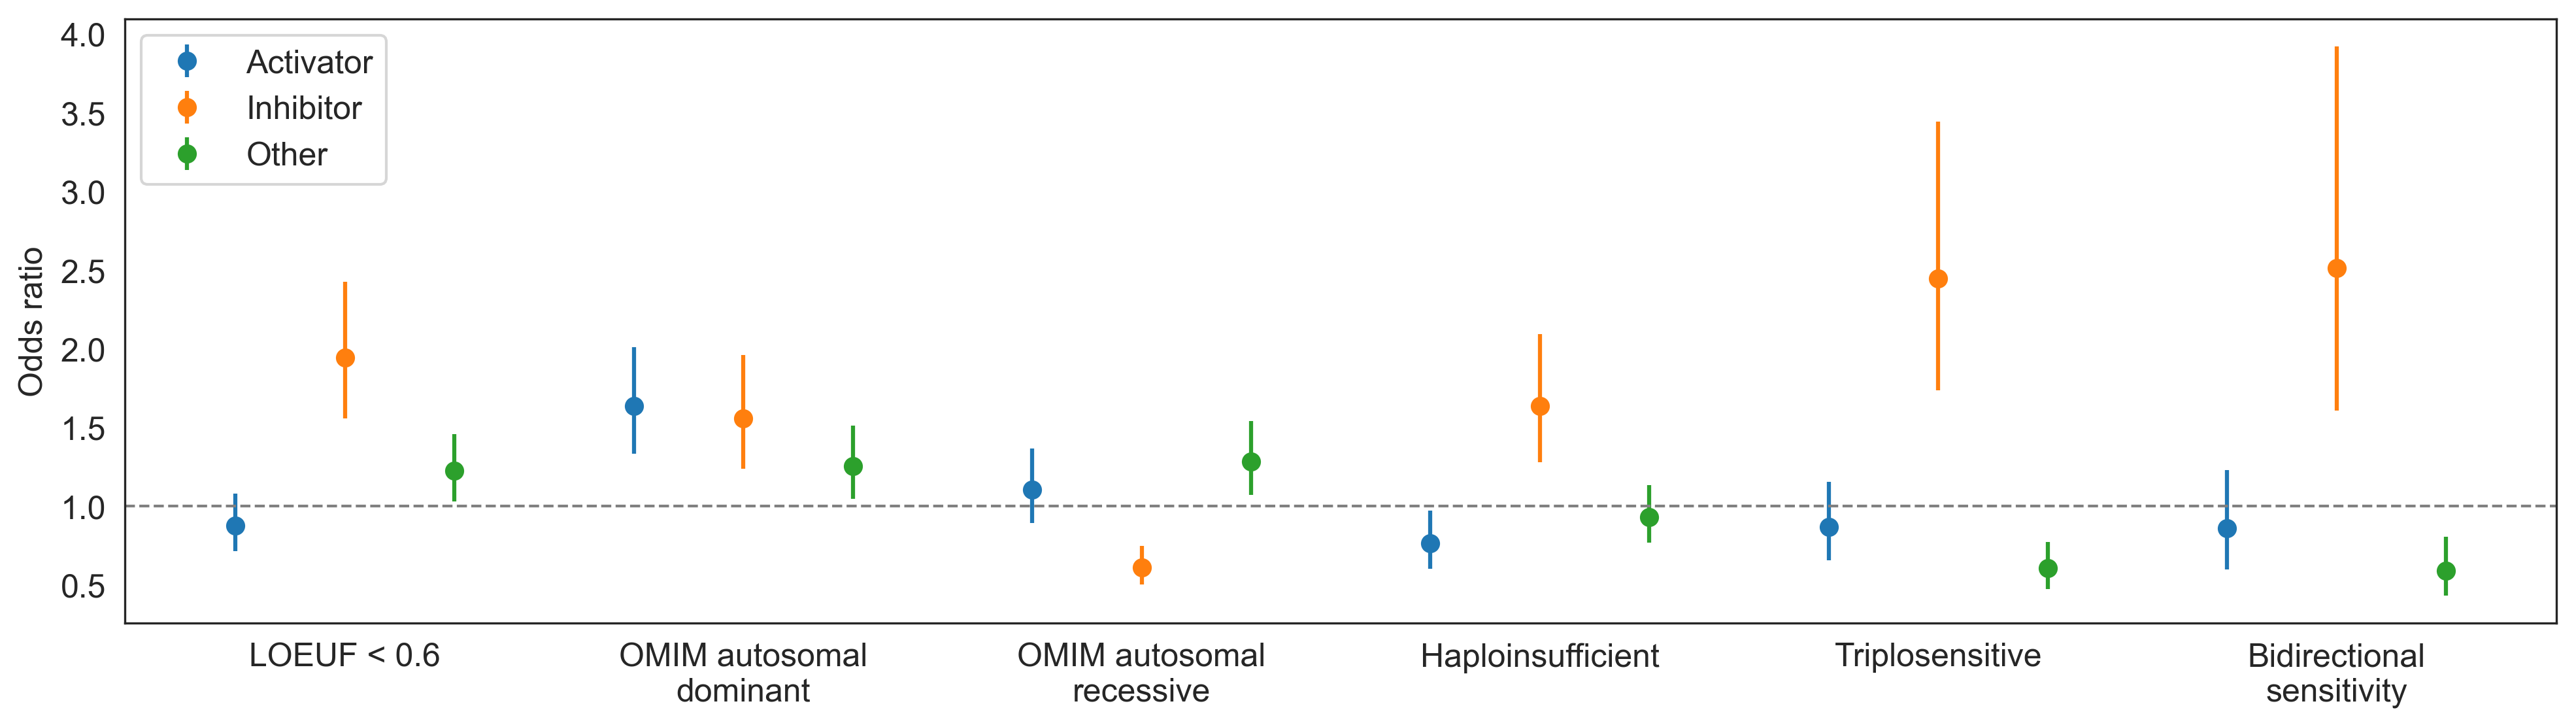

In [51]:
sns.set_style('white')

fig, ax = plt.subplots(figsize=(16,4), dpi=300)
mechanisms = res['Mechanism'].unique()
offset = 0.275  # Offset for dodging
x_positions = range(len(res['Column'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['Mechanism'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['OR'], 
                yerr=[subset['OR'] - subset['CI_lower'], subset['CI_upper'] - subset['OR']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['Column'].unique())))
ax.set_xticklabels(res['Column'].unique())
ax.legend(title='', loc='upper left')

plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel('')
plt.ylabel('Odds ratio')


In [53]:
res = []

for col in ['loc_intracellular','loc_membrane','loc_secreted','loc_plasma']:
    temp2 = tg[['neg','pos','other',col]]
    temp2['xvar'] = temp2[col].copy()
    temp2 = temp2.dropna(subset='xvar')

    if temp2['xvar'].abs().sum() >= 10:
        for mechanism in ['neg','other','pos']:
            try:
                X1 = sm.add_constant(temp2['xvar'])
                y1 = temp2[mechanism]
                model1 = sm.Logit(y1, X1).fit(disp=0)
                or_1 = np.exp(model1.params['xvar'])
                ci_1 = np.exp(model1.conf_int().loc['xvar'])
                pval = model1.pvalues['xvar']
                res.append({'Column':col,'Mechanism':mechanism,'OR':or_1,'CI_lower':ci_1[0],'CI_upper':ci_1[1],'p':pval})
            except:
                continue
                
res = pd.DataFrame(res)
res['Mechanism'] = res['Mechanism'].map({'neg':'Inhibitor','pos':'Activator','other':'Other'})
res['Column'] = res['Column'].map({'loc_intracellular':'Intracellular','loc_membrane':'Membrane',
                                   'loc_plasma':'Plasma','loc_secreted':'Secreted'})
res = res.dropna().sort_values(['Column','Mechanism'])


Text(0, 0.5, 'Odds ratio')

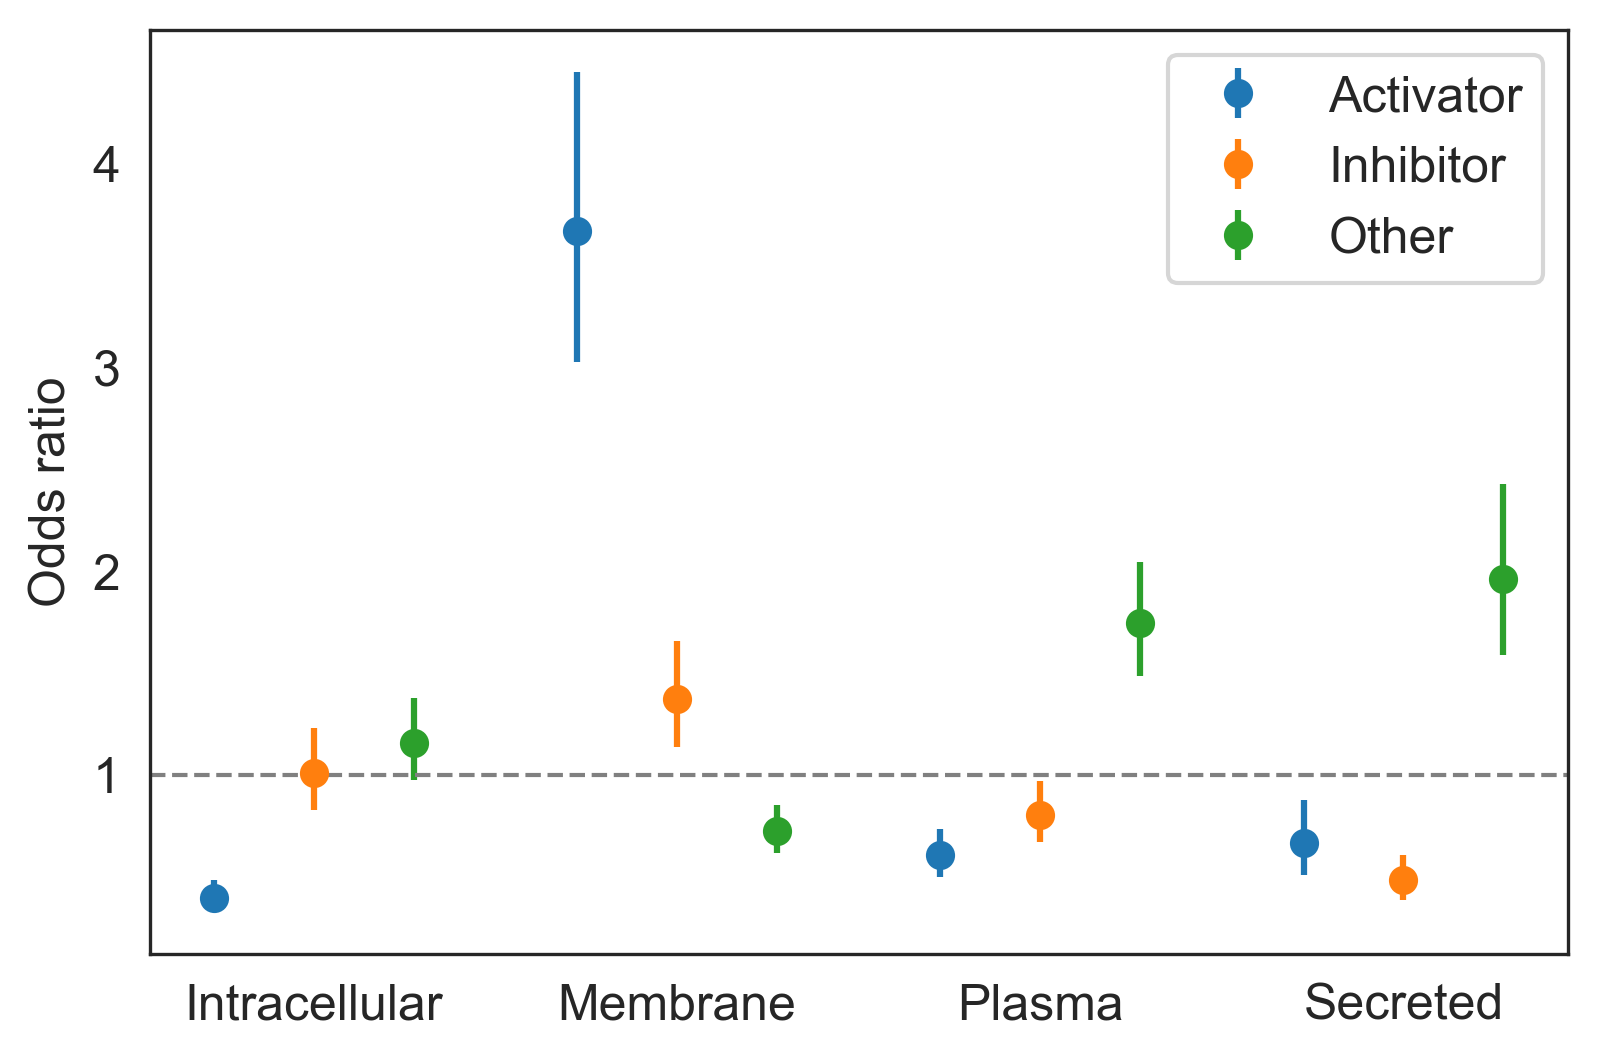

In [56]:
sns.set_style('white')

fig, ax = plt.subplots(figsize=(6.1,4), dpi=300)
mechanisms = res['Mechanism'].unique()
offset = 0.275  # Offset for dodging
x_positions = range(len(res['Column'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['Mechanism'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['OR'], 
                yerr=[subset['OR'] - subset['CI_lower'], subset['CI_upper'] - subset['OR']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['Column'].unique())))
ax.set_xticklabels(res['Column'].unique())
ax.legend(title='')

plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel('')
plt.ylabel('Odds ratio')


In [32]:
res = []

for col in ['class_enzyme','class_transporter','class_tf','class_gpcr','class_vgic']:
    temp2 = tg[['neg','pos','other',col]]
    temp2['xvar'] = temp2[col].copy()
    temp2 = temp2.dropna(subset='xvar')

    if temp2['xvar'].abs().sum() >= 10:
        for mechanism in ['neg','other','pos']:
            try:
                X1 = sm.add_constant(temp2['xvar'])
                y1 = temp2[mechanism]
                model1 = sm.Logit(y1, X1).fit(disp=0)
                or_1 = np.exp(model1.params['xvar'])
                ci_1 = np.exp(model1.conf_int().loc['xvar'])
                pval = model1.pvalues['xvar']
                res.append({'Column':col,'Mechanism':mechanism,'OR':or_1,'CI_lower':ci_1[0],'CI_upper':ci_1[1],'p':pval})
            except:
                continue
                
res = pd.DataFrame(res)
res['Mechanism'] = res['Mechanism'].map({'neg':'Inhibitor','pos':'Activator','other':'Other'})
res['Column'] = res['Column'].map({'class_enzyme':'Enzyme','class_gpcr':'GPCR','class_tf':'TF',
                                   'class_transporter':'Transporter','class_vgic':'VGIC'})
res = res.dropna().sort_values(['Column','Mechanism'])


Text(0, 0.5, 'Odds ratio')

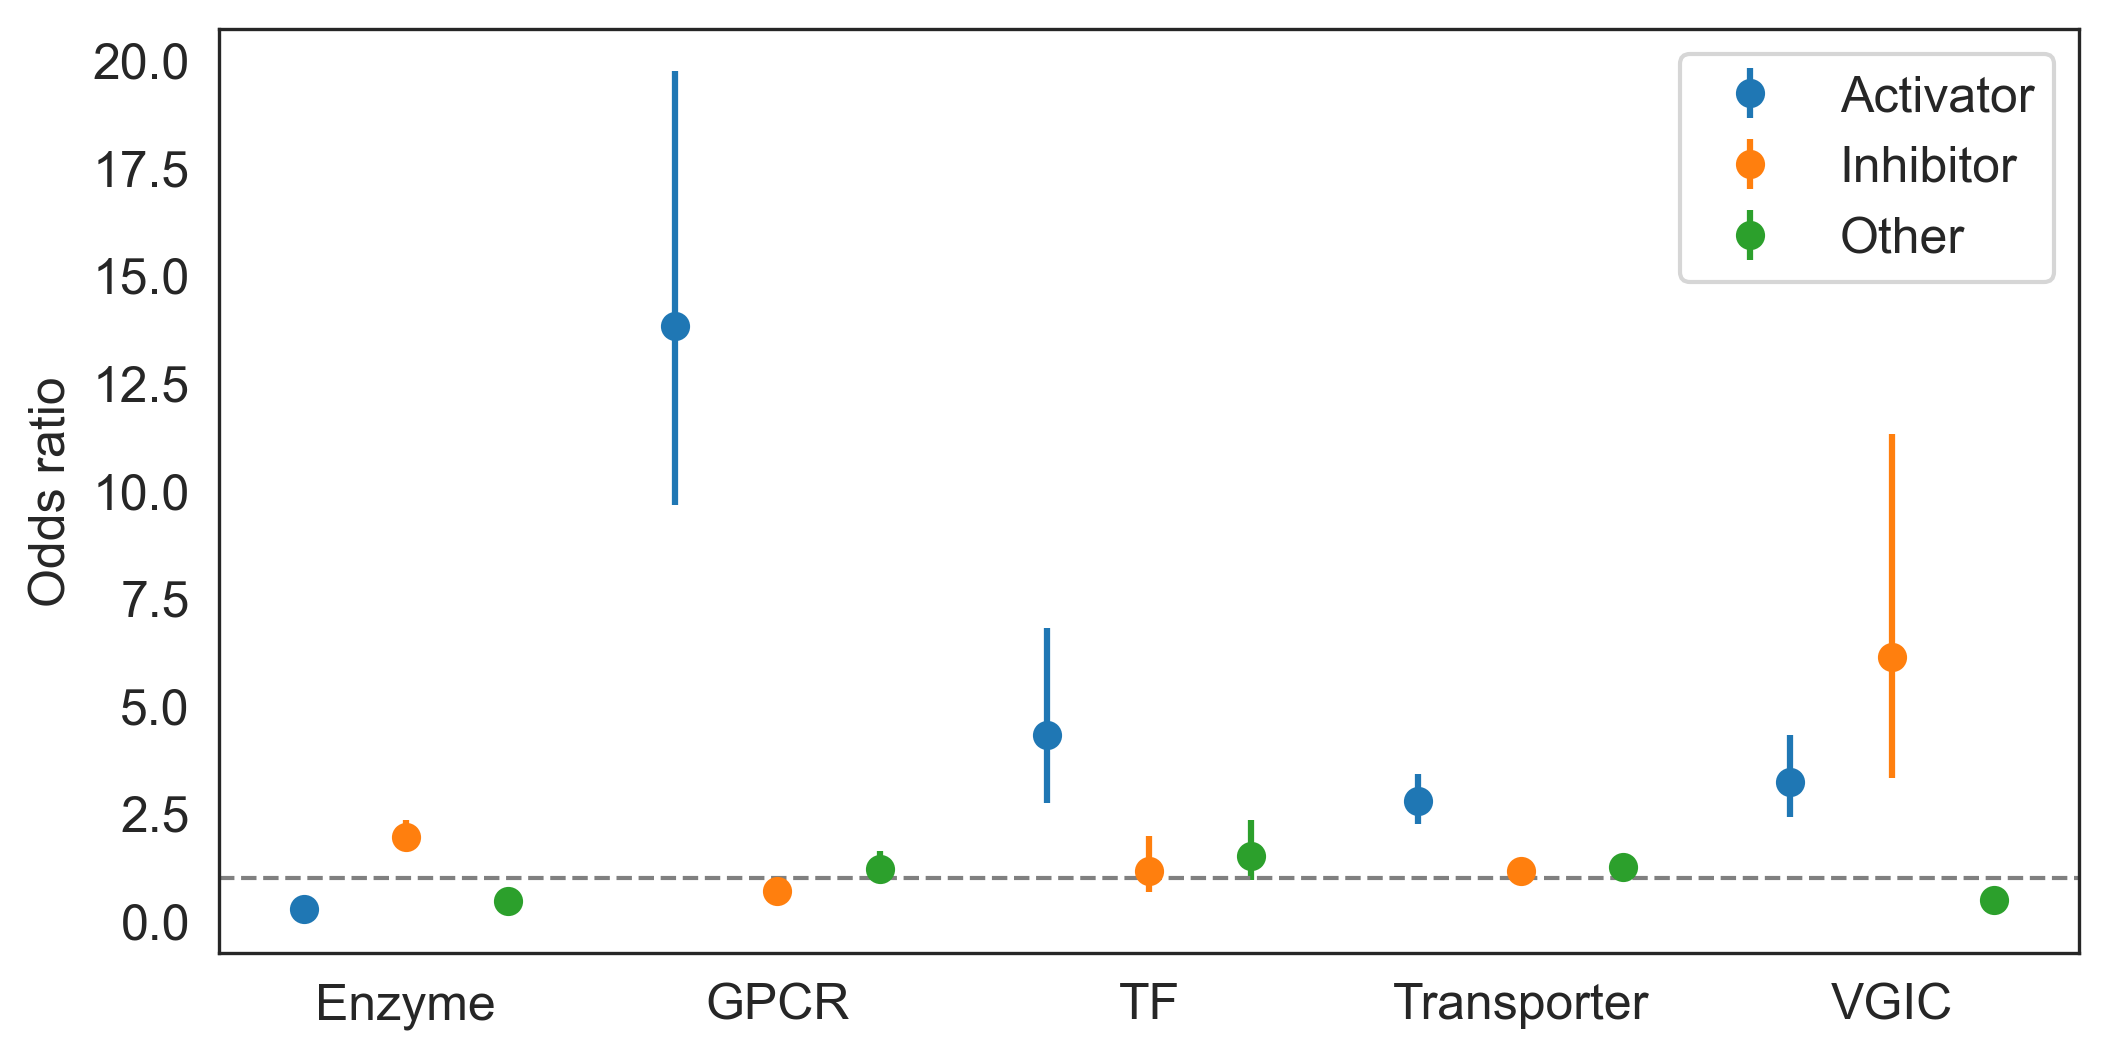

In [35]:
sns.set_style('white')

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
mechanisms = res['Mechanism'].unique()
offset = 0.275  # Offset for dodging
x_positions = range(len(res['Column'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['Mechanism'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['OR'], 
                yerr=[subset['OR'] - subset['CI_lower'], subset['CI_upper'] - subset['OR']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['Column'].unique())))
ax.set_xticklabels(res['Column'].unique())
ax.legend(title='')

plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel('')
plt.ylabel('Odds ratio')


## Distributions of gene characteristics

In [3]:
genes = pd.read_pickle('./OT/Final/protein_coding_genes.pkl')
genes['label'] = 'All protein coding'
genes = genes.loc[~genes['gene'].str.contains('ENSG')]

pharos = pd.read_csv('./Other/pharos.csv')
pharos = pharos.loc[pharos['Target Development Level'].isin(['Tclin','Tchem'])]
pharos = pharos.loc[pharos['Symbol'].isin(genes['gene'])][['Symbol']].set_axis(['gene'],axis=1)
pharos['label'] = 'Druggable'

kdg = pd.read_pickle('./Drugs/targets.pkl')
kdg = kdg.loc[kdg['gene'].isin(genes['gene'])]
kdg['label'] = 'Druggable'
kdg = kdg[['gene','label']]

tg = pd.read_pickle('./Drugs/targets.pkl')[['gene','moa']]
tg = tg.loc[tg['gene'].isin(genes['gene'])]
tg['value'] = 1
tg = pd.pivot_table(tg, index='gene', columns='moa', values='value').fillna(0).reset_index()
tg = tg.set_axis(['gene','moa_neg','moa_other','moa_pos'],axis=1)
tg['label'] = tg.apply(
    lambda row: (
        'Inhibitor ± other' if row['moa_neg'] == 1 and row['moa_pos'] == 0 else
        'Activator ± other' if row['moa_neg'] == 0 and row['moa_pos'] == 1 else
        'Activator and inhibitor' if row['moa_neg'] == 1 and row['moa_pos'] == 1 else
        'Only other'
    ),
    axis=1
)
tg = tg[['gene','label']]

gd = pd.concat([genes,pharos,kdg,tg]).drop_duplicates()
cs = pd.read_pickle('./Features/constraint.pkl')
tp = pd.read_pickle('./Features/tp.pkl').fillna(0)
ess = pd.read_pickle('./Features/ess_haplo.pkl')
orig = gd.copy()

gd = orig.loc[orig['gene'].isin(cs['gene'])]
names = gd.groupby('label')['gene'].nunique().reset_index()
names['name'] = names['label'] + '\n(' + names['gene'].astype(str) + ')'
gd = gd.merge(names[['label', 'name']])
gd['label'] = pd.Categorical(gd['label'], ['All protein coding','Druggable','Activator ± other',
                                           'Inhibitor ± other','Activator and inhibitor','Only other'])

# Dynamically update counts
label_counts_cs = names.set_index('label')['gene'].to_dict()
gd['name'] = pd.Categorical(gd['label'].map(lambda x: f"{x}\n({label_counts_cs[x]})"),
                             categories=[f"{label}\n({label_counts_cs[label]})" for label in label_counts_cs])
cs = cs.merge(gd)
cs['name'] = pd.Categorical(cs['name'], cs.sort_values('label')['name'].drop_duplicates().to_list())

gd = orig.loc[orig['gene'].isin(tp['gene'])]
names = gd.groupby('label')['gene'].nunique().reset_index()
names['name'] = names['label'] + ' (' + names['gene'].astype(str) + ')'
gd = gd.merge(names[['label', 'name']])
gd['label'] = pd.Categorical(gd['label'], ['All protein coding','Druggable','Activator ± other',
                                           'Inhibitor ± other','Activator and inhibitor','Only other'])

# Dynamically update counts
label_counts_tp = names.set_index('label')['gene'].to_dict()
gd['name'] = pd.Categorical(gd['label'].map(lambda x: f"{x} ({label_counts_tp[x]})"),
                             categories=[f"{label} ({label_counts_tp[label]})" for label in label_counts_tp])
tp = tp.merge(gd)
tp['name'] = pd.Categorical(tp['name'], tp.sort_values('label')['name'].drop_duplicates().to_list())

gd = orig.loc[orig['gene'].isin(ess.dropna(subset=['collins_phaplo', 'collins_ptriplo'])['gene'])]
names = gd.groupby('label')['gene'].nunique().reset_index()
names['name'] = names['label'] + '\n(' + names['gene'].astype(str) + ')'
gd = gd.merge(names[['label', 'name']])
gd['label'] = pd.Categorical(gd['label'], ['All protein coding','Druggable','Activator ± other',
                                           'Inhibitor ± other','Activator and inhibitor','Only other'])

# Dynamically update counts
label_counts_ess = names.set_index('label')['gene'].to_dict()
gd['name'] = pd.Categorical(gd['label'].map(lambda x: f"{x}\n({label_counts_ess[x]})"),
                             categories=[f"{label}\n({label_counts_ess[label]})" for label in label_counts_ess])
ess = ess.merge(gd)
ess['name'] = pd.Categorical(ess['name'], ess.sort_values('label')['name'].drop_duplicates().to_list())


In [9]:
print(ranksums(cs.loc[cs['label'] == 'All protein coding']['lof.oe_ci.upper'].dropna(),
               cs.loc[cs['label'] == 'Druggable']['lof.oe_ci.upper'].dropna()))
print(ranksums(cs.loc[cs['label'] == 'Inhibitor ± other']['lof.oe_ci.upper'].dropna(),
               cs.loc[cs['label'] == 'Activator ± other']['lof.oe_ci.upper'].dropna()))

RanksumsResult(statistic=13.87201720764454, pvalue=9.360676833177875e-44)
RanksumsResult(statistic=-5.356842399069791, pvalue=8.468892972330663e-08)


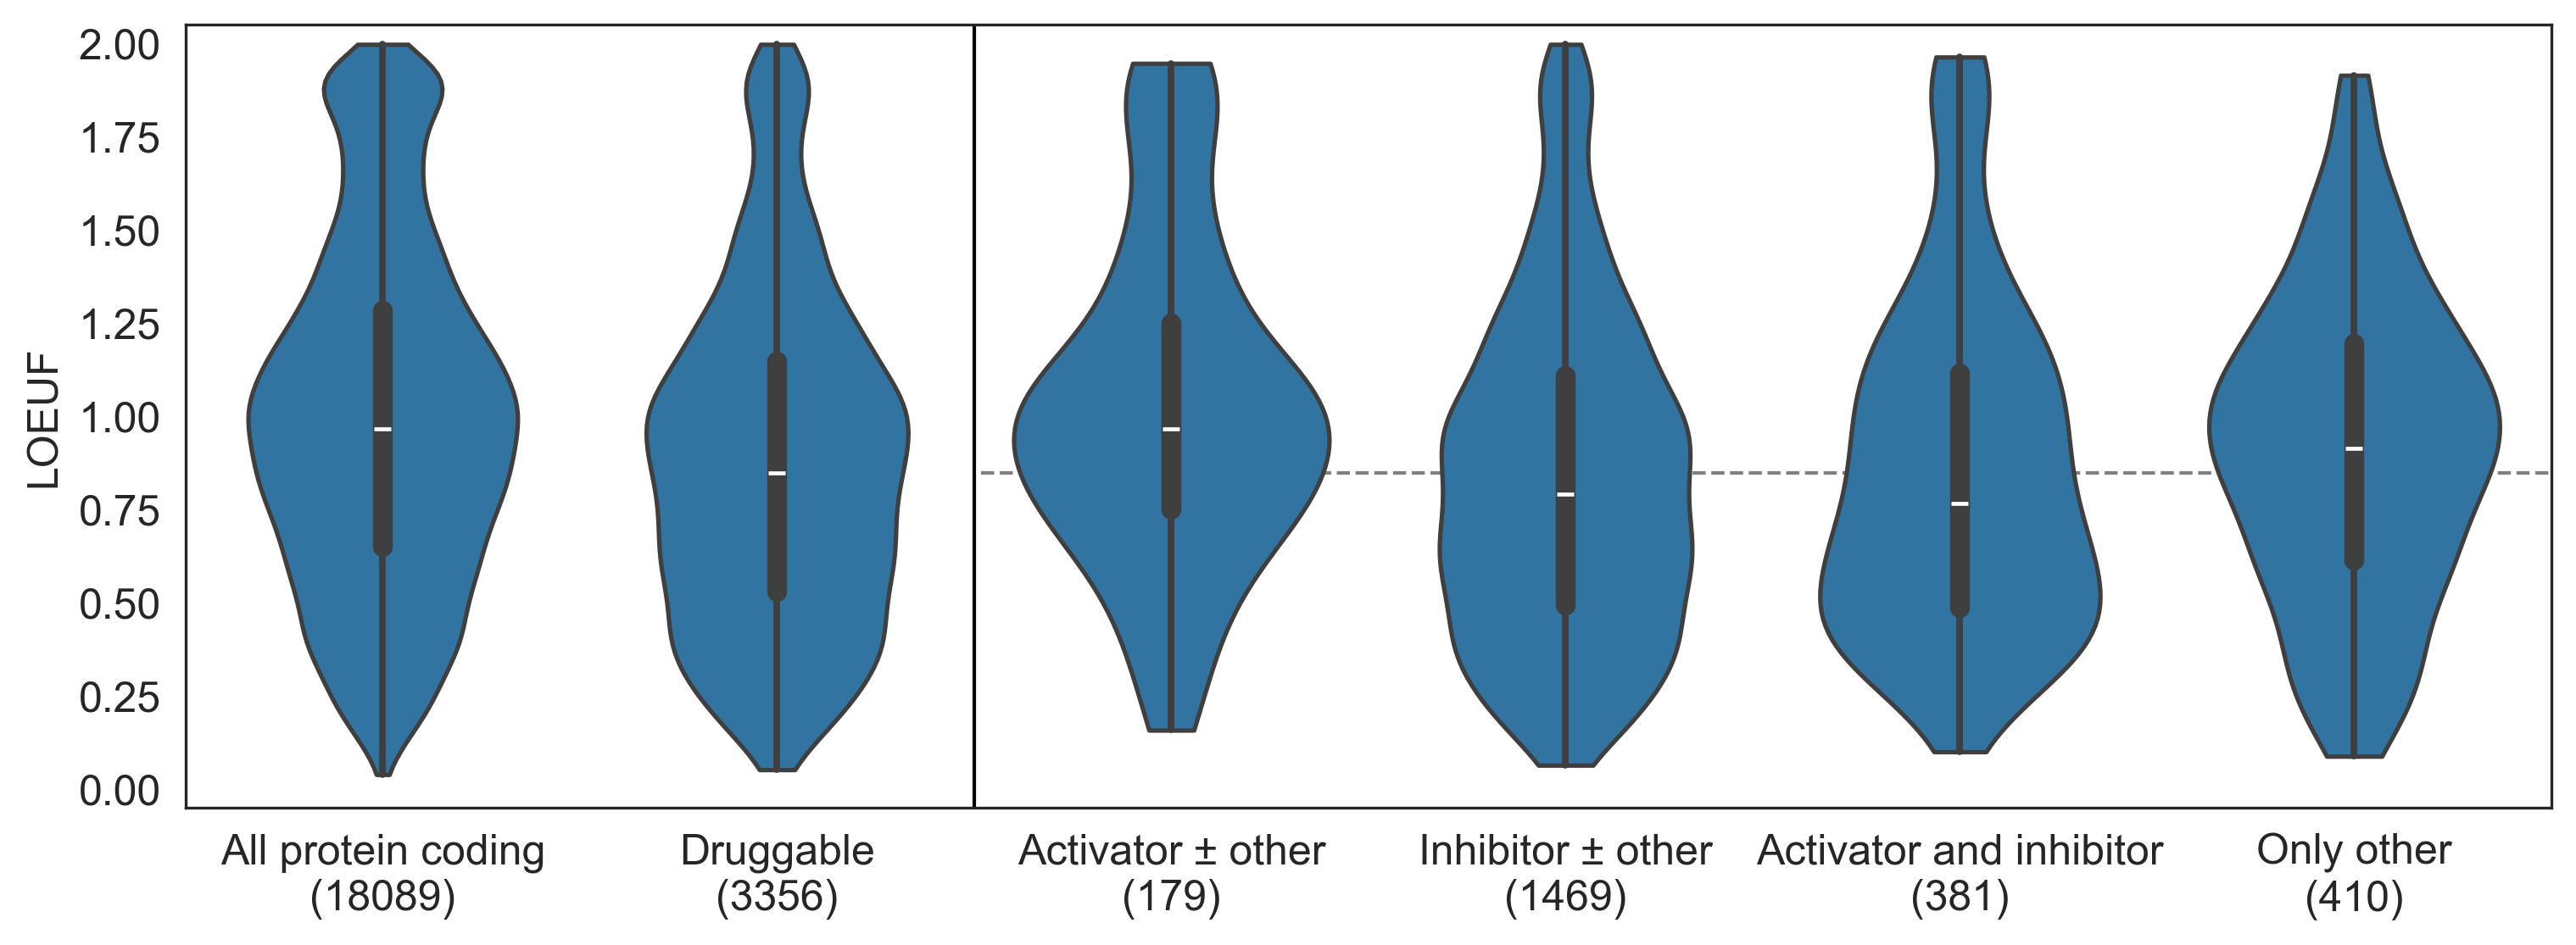

In [36]:
plt.figure(figsize=(12,4), dpi=300)
sns.violinplot(cs, x='name', y='lof.oe_ci.upper', cut=0)
plt.ylim([-0.05,2.05])
plt.xlabel('')
plt.ylabel('LOEUF')
plt.axvline(x=1.5, color='black', linewidth=1)
plt.axhline(y=cs.loc[cs['label'] == 'Druggable']['lof.oe_ci.upper'].median(), xmin=1.85/plt.xlim()[1], color='gray', linestyle='--', zorder=0, linewidth=1)


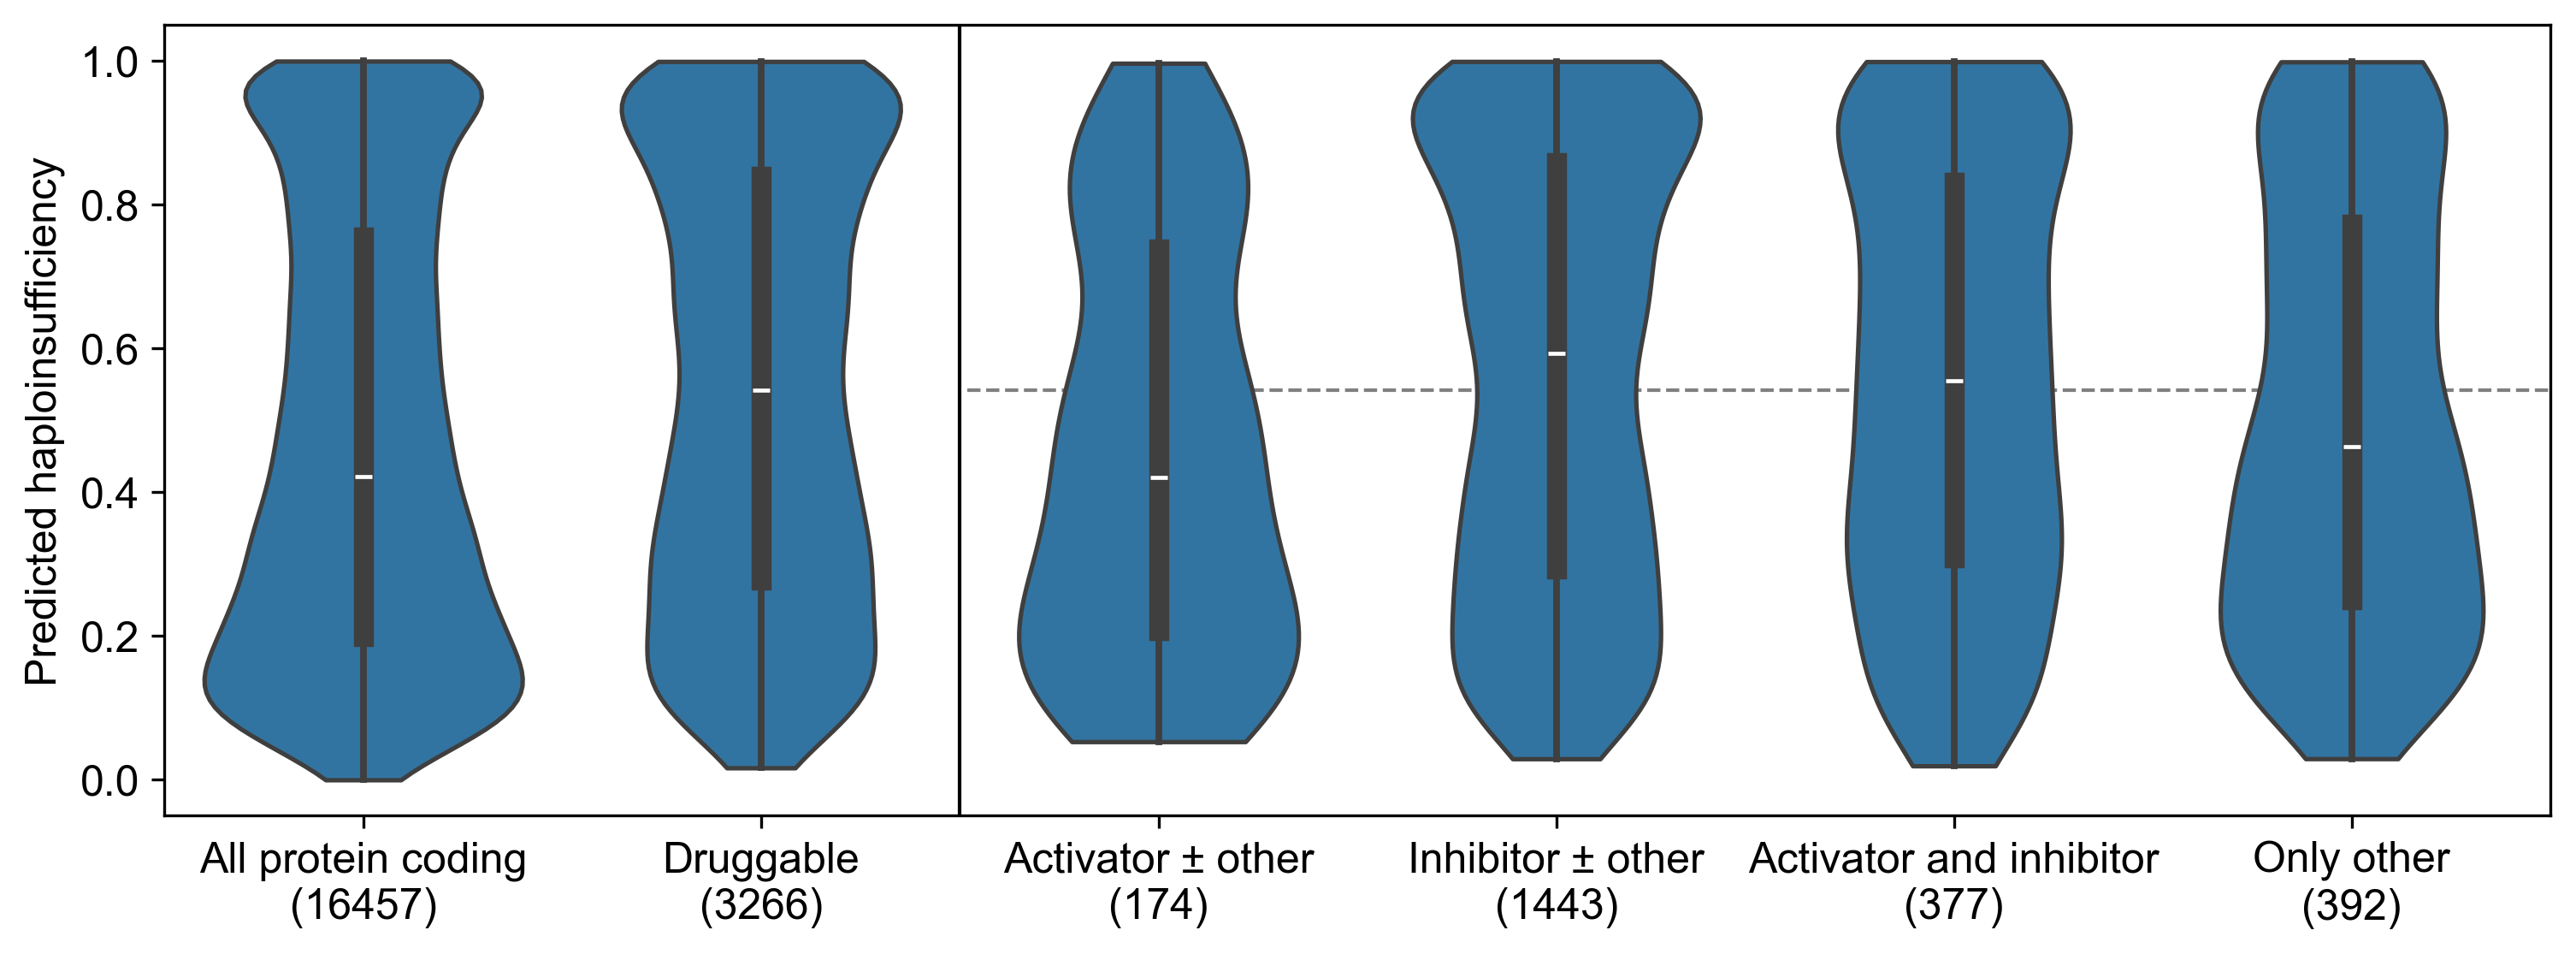

In [4]:
plt.figure(figsize=(12,4), dpi=300)
sns.violinplot(ess, x='name', y='collins_phaplo', cut=0)
plt.ylim([-0.05,1.05])
plt.xlabel('')
plt.ylabel('Predicted haploinsufficiency')
plt.axvline(x=1.5, color='black', linewidth=1)
plt.axhline(y=ess.loc[ess['label'] == 'Druggable']['collins_phaplo'].median(), xmin=1.85/plt.xlim()[1], color='gray', linestyle='--', zorder=0, linewidth=1)


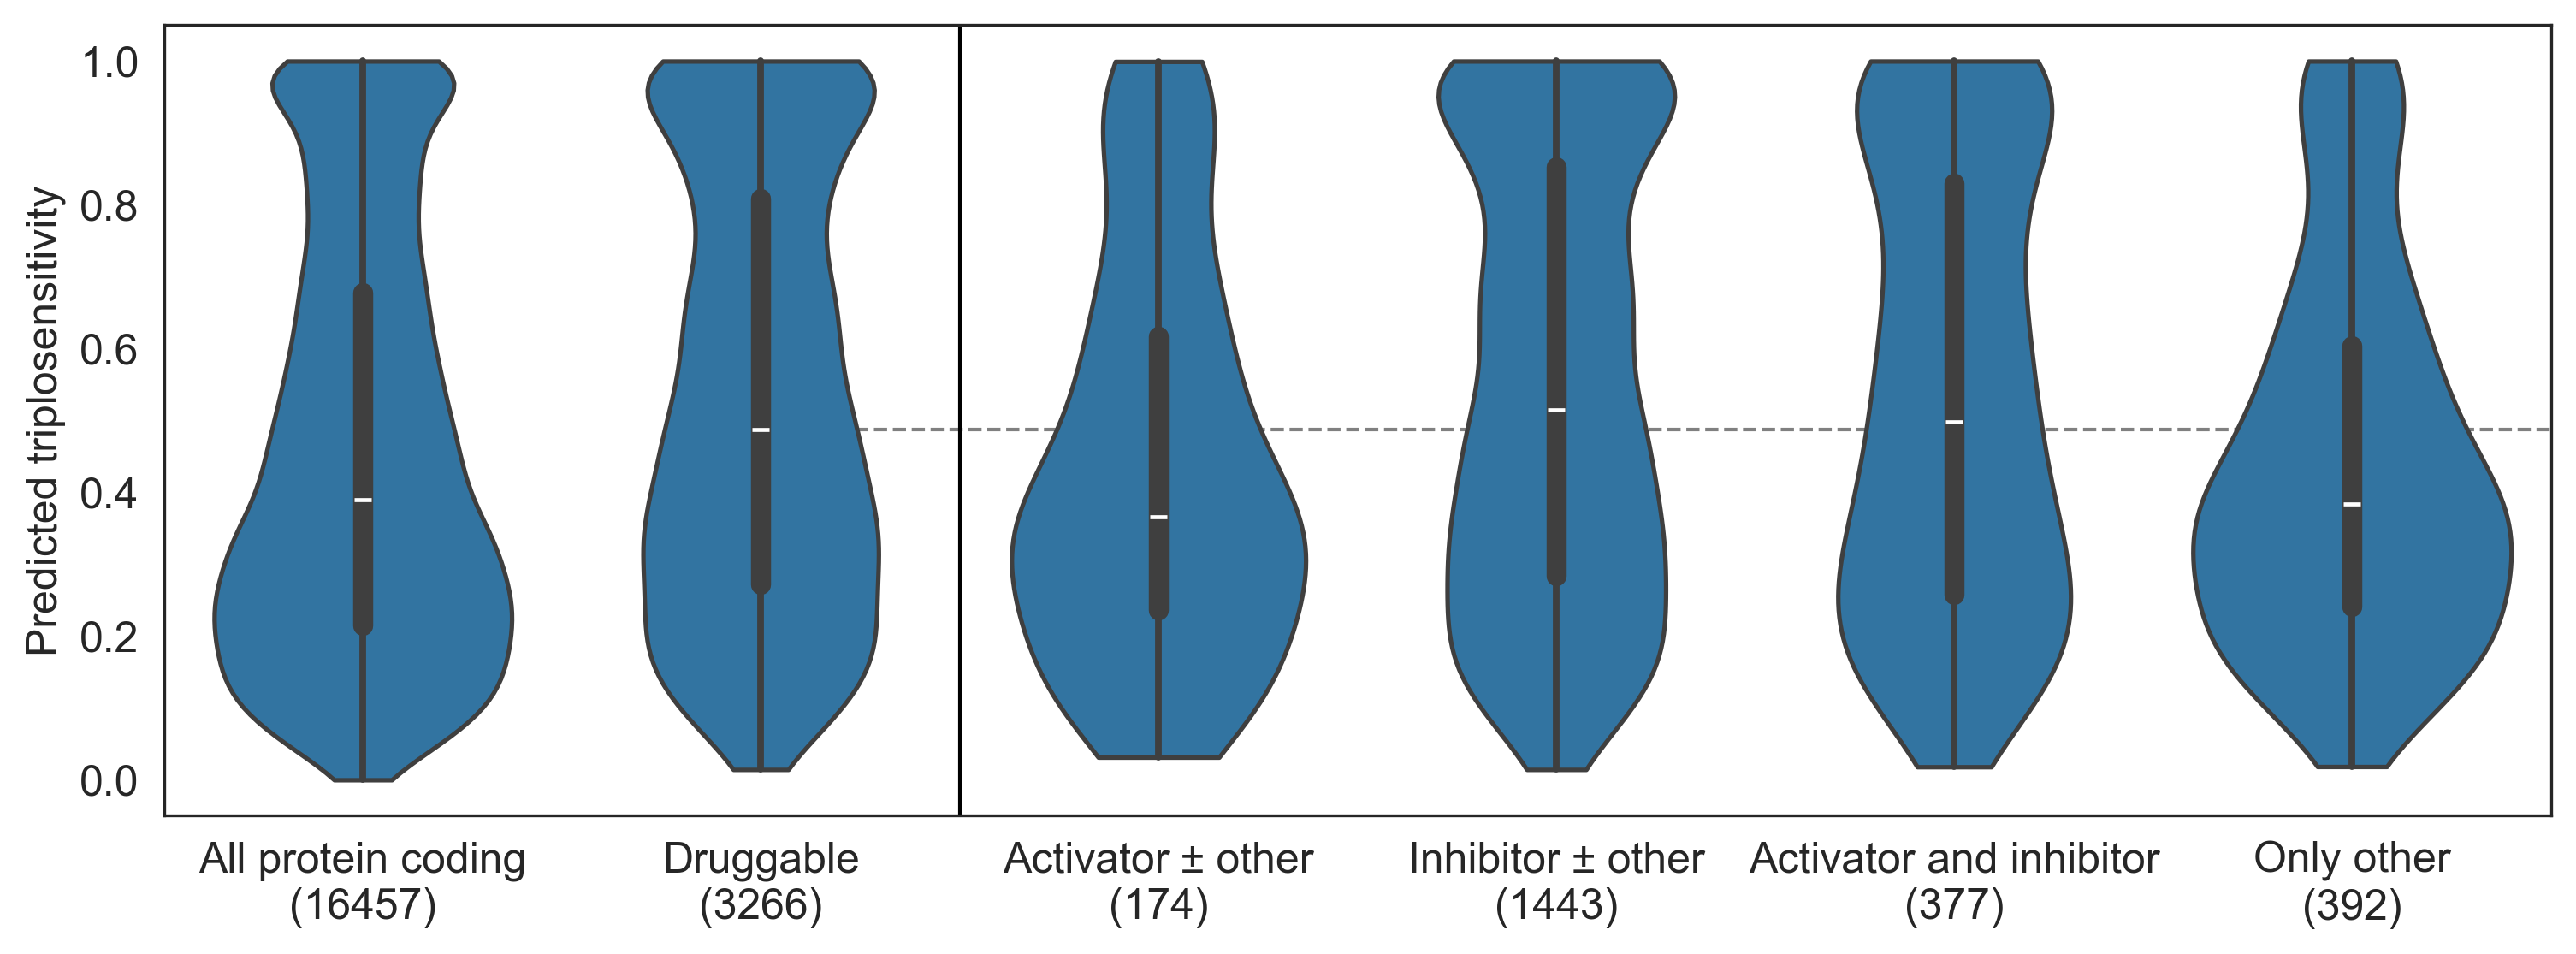

In [5]:
plt.figure(figsize=(12,4), dpi=300)
sns.set_style('white')

sns.violinplot(ess, x='name', y='collins_ptriplo', cut=0)
plt.ylim([-0.05,1.05])
plt.xlabel('')
plt.ylabel('Predicted triplosensitivity')
plt.axvline(x=1.5, color='black', linewidth=1)
plt.axhline(y=ess.loc[ess['label'] == 'Druggable']['collins_ptriplo'].median(), xmin=0.25, color='gray', linestyle='--', zorder=0, linewidth=1)
